# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras
import random

Using TensorFlow backend.


In [2]:
#Set seeds
random.seed(1)
np.random.seed(1)

# GLOBAL VARS

In [14]:
INDIVIDUALS = 50
P_CROSS = 0.8
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [5]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [7]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("../../Models/CNN_CIFAR10_net3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [8]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=1):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)

def uniform(p1, p2):
    LEN=1024
    for i in range(LEN):
        if np.random.uniform() > P_CROSS:
            a = p1[i]
            p1[i] = p2[i]
            p2[i] = a
    return p1, p2

In [10]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  pop.append(uniform(parent1,parent2))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [11]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [12]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [13]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6014373516035515, -0.6031622739363924, -0.6021485086755234, -0.601741746457449, -0.6018262434298753, -0.5999683115278693, -0.6011019133110449, -0.6018546164688894, -0.602045330949718, -0.6003427506625755, -0.600143350373014, -0.6013892919160629, -0.6033343443247148, -0.6019187889890968, -0.6011185529777043, -0.6012733828694594, -0.6005657418939698, -0.60073975641488, -0.6003331447464575, -0.6019419132727197, -0.6015050957705956, -0.6014536216682402, -0.6024943175519134, -0.6003246467251564, -0.6011354402502284, -0.6004615273710654, -0.6009395239603137, -0.6017868262546429, -0.6046245155173342, -0.600278243747419, -0.6003983511800848, -0.6014501601309896, -0.6001528784822656, -0.6018962381725588, -0.601237153091195, -0.6005116260097789, -0.6021131766167505, -0.6005688650076277, -0.600498764652647, -0.6001520371139413, -0.5999884153041479, -0.6009746317056359, -0.6000052210214936, -0.6012808696707932, -0.6038307841459971, -0.5998767937244269, -0.6034653991653722, -

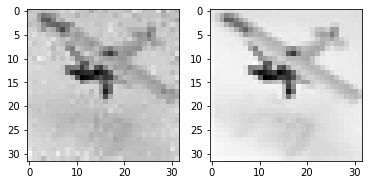

True label: 0
predicted label: 2
Time:  477.06609582901  seconds
Initial fitness: 
 [-0.5083109251333466, -0.5056567168463367, -0.4936917468912667, -0.5213173586089217, -0.4162122464996342, -0.5368836342543937, -0.5097406067170367, -0.48069251358431686, -0.51172119876309, -0.5055990595761246, -0.5063395320540487, -0.3898163458405348, -0.48577676356207544, -0.5010846830583635, -0.4208451864691961, -0.5194871725789308, -0.533227846964754, -0.37853476218279447, -0.4970312011442392, -0.5336336646334631, -0.48976058528331834, -0.5310755098938743, -0.5201744120587718, -0.5007515880144726, -0.4956195422927605, -0.5040000130921184, -0.5064895957289517, -0.39451294906340195, -0.503497885613829, -0.49110554989271793, -0.5118156672612941, -0.4945550189525312, -0.41678475792784886, -0.45399788195001967, -0.5124549525918213, -0.5094429426777847, -0.5338599020875899, -0.4035405386714713, -0.5184434875994192, -0.49380667394425026, -0.534671674057756, -0.5248886215461674, -0.5398008764135649, -0.47982

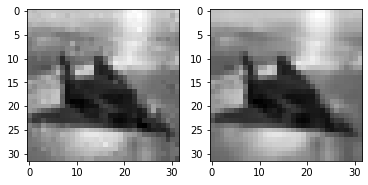

True label: 0
predicted label: 8
Time:  220.3682358264923  seconds
Initial fitness: 
 [-0.359357165462888, -0.37730679562677294, -0.44029576230118395, -0.324859788253532, -0.380338204083905, -0.2930549802190463, -0.2077223531188769, -0.29055509489779585, -0.274998111539573, -0.33336443900741414, -0.3216664668011027, -0.40464482164910276, -0.2553890940162793, -0.3606582069214277, -0.36397145286751753, -0.2804505938805335, -0.2889451170111811, -0.3301835360253973, -0.26242101258299744, -0.4371705029562928, -0.18709979011002667, -0.2984336641545765, -0.27199522359415995, -0.40421940143758284, -0.3283687511352609, -0.21952483958198712, -0.28207243377319147, -0.33176549284773366, -0.39143851079467584, -0.43516964406842196, -0.18535946006171333, -0.32819231664142734, -0.31422953384907004, -0.46375225742241766, -0.306892336731611, -0.42437308537995166, -0.33953483784641403, -0.18672900958703445, -0.296618386184086, -0.40716170283647785, -0.3822958794213158, -0.4329647634197523, -0.02998654407

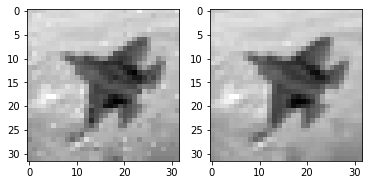

True label: 0
predicted label: 2
Time:  167.76454734802246  seconds
Initial fitness: 
 [-0.5915289720564044, -0.5931016143278723, -0.592776981701156, -0.592573672676522, -0.5946355946728532, -0.5936950006566617, -0.5938662995759058, -0.5940482397931677, -0.5930681118515526, -0.5913590734565762, -0.5933729268027303, -0.595898046709928, -0.5922129863767048, -0.5931661363187951, -0.595100122304205, -0.595734363482701, -0.5937145321850298, -0.5946780524720559, -0.592855505312601, -0.5923979643588144, -0.5942834161007153, -0.5938843485573118, -0.592822995388792, -0.5941291248071979, -0.5952099692702625, -0.5962598103370157, -0.5945696819987918, -0.5948055009926669, -0.5904059887222277, -0.5957292329477305, -0.591630404954852, -0.5936391136150205, -0.5919477851923105, -0.5946170383624471, -0.5782346814487643, -0.5936532081472381, -0.59022053603594, -0.5944947415565578, -0.5909753132609847, -0.5965506393630104, -0.5969917801662875, -0.5935547084787701, -0.5956116459391971, -0.5950105597756536

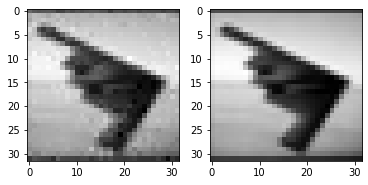

True label: 0
predicted label: 2
Time:  372.9871060848236  seconds
Initial fitness: 
 [-0.557601662840386, -0.5411949861764691, -0.5081913069495507, -0.5537075264256015, -0.5802426684543361, -0.5304464998693328, -0.5174296449146326, -0.5414694112072302, -0.5455482669730779, -0.5560390810807397, -0.5493367640074964, -0.5177697696735567, -0.5648929829073811, -0.5691915908226558, -0.5486235112658788, -0.5482756926423406, -0.5527283896443601, -0.5328777888832446, -0.5140583793302774, -0.5464026764633846, -0.5639980566888346, -0.49888045342809567, -0.5423106732346464, -0.5536350373725001, -0.543650338923151, -0.5337086568921308, -0.5290476940747091, -0.5395412427120159, -0.5322061174183172, -0.5498185945947356, -0.5418746515145542, -0.5470399111455303, -0.4556213125496653, -0.5802578141893255, -0.5290269103123264, -0.5672257806259002, -0.5423909921744107, -0.4692419334422271, -0.5303330951713541, -0.5823270211223681, -0.5363767484372141, -0.538769836802677, -0.5387650898991667, -0.580404203

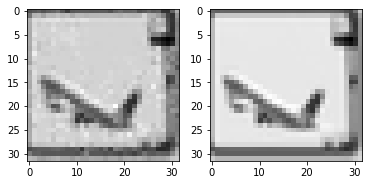

True label: 0
predicted label: 2
Time:  519.8045241832733  seconds
Initial fitness: 
 [-0.6054622315631673, -0.6109223861299702, -0.5908013740522012, -0.6102323365431581, -0.5984650616142277, -0.6152304872775357, -0.6044856452333662, -0.6009165876560798, -0.6137607530662849, -0.5870622528616809, -0.6078723545060792, -0.6009491017819841, -0.615901561871455, -0.6052425027773237, -0.5976719252699261, -0.6075185660569453, -0.604719444952405, -0.6011382120492638, -0.6029678780104691, -0.6070840190823523, -0.6082172069089729, -0.6096483585689728, -0.5964848099609203, -0.5962973769103277, -0.5912216556736192, -0.5933290107163648, -0.5957338600338637, -0.592900315476824, -0.6061383386741113, -0.6021555562474985, -0.5919669267141822, -0.5947454905057584, -0.58063964767681, -0.5946954322246527, -0.5895712434163054, -0.6007655399500776, -0.6076593576957922, -0.6102511319709798, -0.6066316088345062, -0.605245950454602, -0.6007897470326373, -0.5976362326848048, -0.6006032098294829, -0.6090495172668

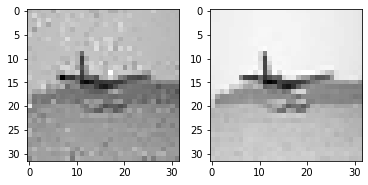

True label: 0
predicted label: 8
Time:  398.76613211631775  seconds
Initial fitness: 
 [-0.6013648365873561, -0.6052871602403954, -0.6034745203188674, -0.6041382539135187, -0.6010402837317989, -0.6010770585480669, -0.6032190041538176, -0.5999773703040694, -0.6006850989298447, -0.6054497389755898, -0.6053446398792688, -0.6036032346539157, -0.6012991798736541, -0.604410326327044, -0.6022561551652843, -0.6012514052184625, -0.5999500111453796, -0.6023536066843743, -0.6064535540280176, -0.6010732463007491, -0.6071062102827661, -0.6036067309835388, -0.6025862503954077, -0.6027567890322736, -0.6043238735349052, -0.5998821802834365, -0.6031438290041842, -0.6013994787289912, -0.6007267474430474, -0.5999760996759257, -0.60292523761049, -0.6023595492334749, -0.6027254498940207, -0.6059874936371458, -0.6030999503266219, -0.6042014237496752, -0.6033945752617861, -0.6065014748046886, -0.6033531951403814, -0.6007727536479538, -0.6039267998848105, -0.6007595002912052, -0.6014292601823581, -0.600395197

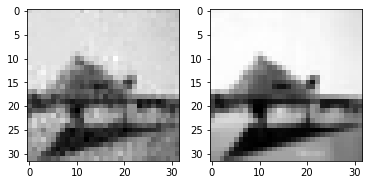

True label: 0
predicted label: 8
Time:  1072.9254591464996  seconds
Initial fitness: 
 [-0.5962463147237315, -0.5956225859479151, -0.5967484625851641, -0.5952184445857122, -0.5951471341755178, -0.5934074625906159, -0.5958987166443713, -0.5959064840123077, -0.5969947942905183, -0.5962685101604372, -0.5964065990315857, -0.596210038344506, -0.5966417081957537, -0.5948964623938238, -0.5948923289304618, -0.5954659530725416, -0.5948311753426423, -0.5936028618542045, -0.5954286852060519, -0.5966040271509638, -0.5968329559614654, -0.5954072273832461, -0.5972349599028963, -0.5956292770770134, -0.5970079494803411, -0.5953219028964324, -0.5961019897020652, -0.5961425205834299, -0.5968937465621147, -0.5963746855466883, -0.5952633552646835, -0.5955900932220628, -0.5958826469027945, -0.5959742786989615, -0.5963924761217894, -0.5969179229849285, -0.5952569717448519, -0.5950762713019787, -0.595699726860353, -0.5959739554252396, -0.5962660117812563, -0.596143905537662, -0.5955714060445937, -0.596044673

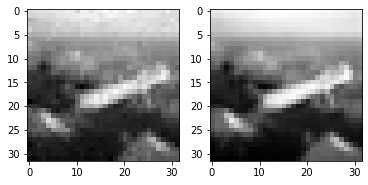

True label: 0
predicted label: 8
Time:  417.68841457366943  seconds
Initial fitness: 
 [-0.5886097072436386, -0.5714653578798272, -0.5813570929478109, -0.5719392352327175, -0.5798490122963567, -0.5760267605904449, -0.5868778244177724, -0.5863691174021288, -0.5696107939801801, -0.5824158909908386, -0.5700684574791925, -0.575459632403674, -0.567006573605676, -0.5814390260799978, -0.5806170416629696, -0.5674497609866933, -0.5711836345717517, -0.5752684167329829, -0.5692364610968709, -0.5751107357720032, -0.5759190660267751, -0.5769971113756043, -0.5852140040953052, -0.5791483444886587, -0.5488350902330928, -0.5768609749746142, -0.5675432772356916, -0.5849755300900574, -0.5873160008458796, -0.574675850458443, -0.5847680348837849, -0.5775251118265473, -0.5904471842056727, -0.5841486726846585, -0.5734349012194314, -0.5740615452725895, -0.578205466605236, -0.5732215493950771, -0.5784812462925135, -0.5926825987758312, -0.5897816581763053, -0.5759781465166607, -0.5686706759993575, -0.5911967505

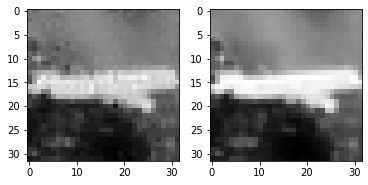

True label: 0
predicted label: 8
Time:  412.6489930152893  seconds
Initial fitness: 
 [0.042403395625521256, -0.35374985612802123, -0.07322990002156599, -0.11472001040398394, -0.32269650986415493, -0.24919657793609862, -0.21633384627992985, -0.10805211172154291, -0.19163655678467778, -0.1537395666645061, 0.14124076476452135, -0.1522619509327842, -0.22033121182340057, -0.1769440086049337, 0.08312843996164734, -0.14068138128748917, 0.0737436830737967, 0.0624073705847725, -0.318734565890864, -0.1185461542401613, -0.10066089373101708, -0.04422140292085022, -0.09511993105103184, 0.15532807180156316, -0.13796545234643792, -0.08377094472383384, 0.28119672754223435, -0.21435348257366948, -0.21525656193465612, -0.11730989994188731, 0.0832126312914235, -0.27792479898908284, -0.33993274880873614, -0.24678822642621404, -0.19584622464343332, -0.22385568471408165, 0.09965861585820603, 0.07785368408492024, -0.1499695717916252, -0.3992539659620473, -0.25941721826016306, -0.14545726074357374, -0.168498

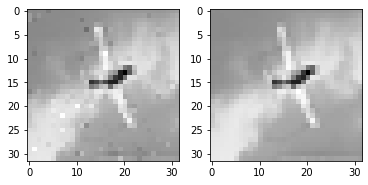

True label: 0
predicted label: 2
Time:  152.01548981666565  seconds
Initial fitness: 
 [-0.4888038304723119, -0.47816296442201345, -0.5491096010292292, -0.4591495265308789, -0.47409963888273454, -0.534574807075717, -0.541434632640843, -0.2563038668588773, -0.5293692479112146, -0.4423832359616384, -0.5115622036832663, -0.5188198422023247, -0.5420464073628475, -0.4759947225294765, -0.5687971907056171, -0.4852777604572389, -0.4859825908422555, -0.533222699311606, -0.49729531869084564, -0.5013540033692746, -0.5121892918897557, -0.5754813959196389, -0.5351288021490741, -0.46557506299803736, -0.4855997757580059, -0.49410705409504996, -0.5045810857748771, -0.5418345711836745, -0.5547811954356234, -0.5479434725368854, -0.5308171588205205, -0.5157500662302953, -0.5035151186846187, -0.4876324496320429, -0.5424814774565018, -0.4743234617838673, -0.49605712780054256, -0.5594450482260568, -0.5615601819355152, -0.5439311145741653, -0.4729937089917242, -0.5461807962716809, -0.5536039125084239, -0.562

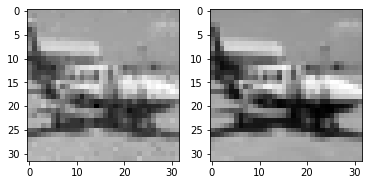

True label: 0
predicted label: 9
Time:  297.1580801010132  seconds
Initial fitness: 
 [0.5379731270219331, 0.4285365400630964, 0.4005220125394181, 0.5603492129384272, 0.524929124682159, 0.5687351228887261, 0.3932284342776225, 0.4016070290769781, 0.4739049077885867, 0.46594182120166827, 0.3920250937143105, 0.41430955636401245, 0.4466930378880619, 0.39235150613190894, 0.375808257176262, 0.38499132644516254, 0.46883619170614566, 0.3964582216680067, 0.3951964404085516, 0.41249005033504726, 0.43147350051482836, 0.39052430013229555, 0.37984671463297726, 0.3953981681806451, 0.4811558652393583, 0.44277631567935527, 0.553121928851417, 0.42298646964228803, 0.5135273793197623, 0.37768520607058603, 0.3689132954321447, 0.3758374804745498, 0.3869717181692945, 0.4572851761684866, 0.5872766138526301, 0.528235939683822, 0.35427483115289793, 0.38471601696717483, 0.47024777247655436, 0.5287815769969181, 0.38002983781155053, 0.4536881343381867, 0.5038133085204504, 0.5017731865629843, 0.38662653854301443, 

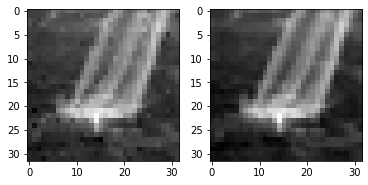

True label: 0
predicted label: 2
Time:  159.29293537139893  seconds
Initial fitness: 
 [-0.43795213043331216, -0.15060355905708037, -0.03216137008762268, -0.19943816629041236, -0.35254208517370245, -0.2762180887694897, -0.38041985984490967, -0.4868603536248659, -0.03131164079139728, -0.28603066637580254, -0.26222805417480993, -0.30809473957527445, 0.08557735526770394, -0.2798206725901751, -0.15863259940906643, -0.1017311141124018, 0.1582495327194437, -0.24406152629261496, -0.3483818551264348, -0.208267240332157, -0.06815586417524039, -0.22984440228596237, -0.27667849057375893, -0.07383048882140963, 0.11780709701828637, 0.06848709190695187, -0.10595397408591672, -0.47676334470627024, -0.3207895232326815, -0.1252302399968226, 0.07955669896910589, -0.4271816424839776, -0.2306678307312429, -0.40055507008753055, -0.2327700188844348, -0.21627546694087402, -0.41533959740340254, -0.22190136908695118, -0.32775170906291823, -0.16999833679488535, -0.11796069000404635, -0.14816559027245346, -0.103

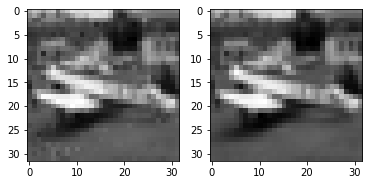

True label: 0
predicted label: 8
Time:  241.5031702518463  seconds
Initial fitness: 
 [-0.6036932616130054, -0.6009960269005357, -0.601471237677477, -0.6004063317039283, -0.6008386968708396, -0.6015226731370986, -0.6024254736551123, -0.6006800539851584, -0.6016849654594835, -0.6029101887613386, -0.601671078966836, -0.6029980711873832, -0.6006201090956584, -0.6011452375660313, -0.6000043459058177, -0.602035311673565, -0.6032621776873599, -0.6006846981470715, -0.6016230827778877, -0.6013027349845754, -0.603972909016532, -0.6022913190218516, -0.6000130186379582, -0.6009313452040075, -0.6008000958382953, -0.6013505236724268, -0.6050014602143827, -0.6046276237933286, -0.6014323111447112, -0.6000805680827141, -0.6008046784199457, -0.6005502224564396, -0.6028659350211966, -0.603976351795822, -0.6008600764749058, -0.6013293784480995, -0.6016576854372219, -0.6016446403464671, -0.6016959156471042, -0.602726204004097, -0.6022198349968719, -0.6010124966633996, -0.6026295732318578, -0.6023186085080

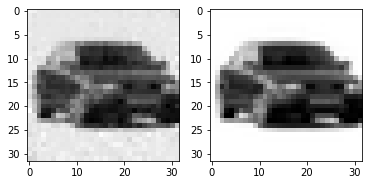

True label: 1
predicted label: 8
Time:  908.8296141624451  seconds
Initial fitness: 
 [-0.5510590612594664, -0.4682486375312074, -0.5137768564618591, -0.5153376638637486, -0.5547472035869132, -0.5519555729213287, -0.519951547124657, -0.5416579789206588, -0.5389109466641671, -0.48409651153036404, -0.5469375992888884, -0.5552797216052827, -0.5520339139958201, -0.49742197862329385, -0.5360508379424971, -0.535138658106702, -0.566424696341152, -0.5085287345444257, -0.5522771960747741, -0.5546763225339926, -0.5439124631161323, -0.5425935846145101, -0.49226262307892865, -0.4918960340773423, -0.5370852512261401, -0.5705074722397628, -0.5378903184084061, -0.5548194672742756, -0.5384590867878656, -0.438587146784585, -0.5418073430002098, -0.5209199684992525, -0.5580435180794714, -0.5430990996392414, -0.5307084624688437, -0.5462463147050779, -0.566307853354274, -0.5438595904039878, -0.5669713265256207, -0.5601285496229488, -0.5388529150843473, -0.5079840325702001, -0.504542494741347, -0.5119788492

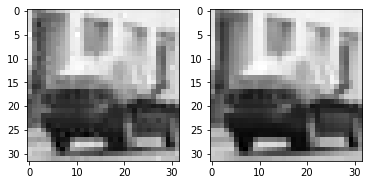

True label: 1
predicted label: 9
Time:  406.29490900039673  seconds
Initial fitness: 
 [-0.6017584633424081, -0.6012314898503351, -0.6009961366280333, -0.6037890988778833, -0.6041223797459607, -0.6006422708406705, -0.6008449854907225, -0.604141210519113, -0.6021390790559541, -0.6001983970897423, -0.6015130089222912, -0.6033671784400063, -0.6011772254946144, -0.6018647818869531, -0.6010478210404079, -0.6062411432679574, -0.6014618316627741, -0.6019938144038728, -0.6001585617936097, -0.6044168352376369, -0.6003756929674051, -0.6017908195963221, -0.6023946492892917, -0.6047550245645581, -0.6041353885412024, -0.6017196481725939, -0.600881667104943, -0.6038192979959909, -0.6002595441729124, -0.6039802252671991, -0.6008073665693034, -0.6028867216004474, -0.6000234601135691, -0.6048339408870821, -0.6006270410136324, -0.6001706203948117, -0.6029934514719653, -0.6000302707870047, -0.6023610871235436, -0.6026581149384642, -0.6048947906939544, -0.6018774228035462, -0.6036552922303001, -0.60005186

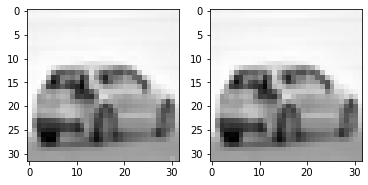

True label: 1
predicted label: 1
Time:  161.41091513633728  seconds
Initial fitness: 
 [0.3978589294618775, 0.4396293835061851, 0.14719287578260493, 0.25035369412626973, 0.5148167695773311, 0.28523309333201413, 0.2808193487989194, 0.4118453992479965, 0.43638321111729184, 0.28987874166278116, 0.333188181757177, 0.2965650862138607, 0.13190487639070247, 0.43156860045732093, 0.44207284248703715, 0.5694135529923194, 0.28319143658453283, 0.3466460456224385, 0.25230036487949237, 0.3733842993665921, 0.2935881539725612, 0.7000354990954119, 0.24301098985394215, 0.1846888663121505, 0.13959471728960868, 0.346870659625089, 0.45697262538322814, 0.24582311586175698, 0.2357838732551001, 0.5943577770230397, 0.46430477796145014, 0.3322503043374905, 0.06286783407394178, 0.10255135375348413, 0.3713734564794807, 0.5266431772027338, 0.2794783832103285, 0.430662611102058, 0.5237359765120064, 0.469143518000523, 0.42055757663936216, 0.09779810737274608, 0.2282279211795601, 0.1822992574107997, 0.271042683770546

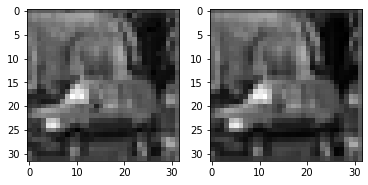

True label: 1
predicted label: 7
Time:  465.85711693763733  seconds
Initial fitness: 
 [0.48896473739021373, 0.5747749775203489, 0.6007405105938028, 0.5247436735870985, 0.4307202731914946, 0.550109553264483, 0.4631610926926405, 0.5750169107618033, 0.5457242863589207, 0.5696467930186468, 0.4469952589685514, 0.5342723151978928, 0.4985666225477181, 0.6668305809251759, 0.5475324537610213, 0.49260767185884646, 0.5625192993346464, 0.582593334178049, 0.6737049538188575, 0.4629761655197321, 0.6001880335453046, 0.6224502113625713, 0.5850052738052662, 0.5622918123457912, 0.590922570646775, 0.5153128907534211, 0.4464321991533573, 0.5148201906166994, 0.5479697813412217, 0.7075830859401585, 0.42200489970496396, 0.5572422717075832, 0.4330556610439838, 0.494700025110484, 0.5120836148024392, 0.603096259595169, 0.584916145617993, 0.6092422898353798, 0.4406891133082128, 0.5910697535662752, 0.5094590388882658, 0.49442987605318384, 0.5937204011399144, 0.557739657135427, 0.5296920660196117, 0.5719940196838

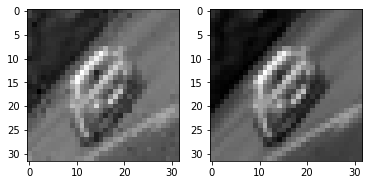

True label: 1
predicted label: 6
Time:  409.7238812446594  seconds
Initial fitness: 
 [-0.5959652626353582, -0.5959087430257901, -0.5905198784232234, -0.5963543911804188, -0.5892528502133632, -0.591646232132604, -0.5963311561590393, -0.5902019601658249, -0.5938064627860603, -0.5851697125747405, -0.5940560698553152, -0.5922098954102677, -0.5924843008632881, -0.5844805454934422, -0.5895763790185555, -0.5966748139075826, -0.5897149936957223, -0.5898674640801136, -0.5899972854943619, -0.5859483371468257, -0.5958631103484993, -0.5849024298649754, -0.5935057757418198, -0.5905084545014487, -0.5926584720835513, -0.5827428860580893, -0.5964515491041045, -0.5428712050683603, -0.5951855420782609, -0.5777754360668336, -0.5824475784917771, -0.5915919338770264, -0.5965207365664357, -0.5943072936651599, -0.5935065453830467, -0.5918077482026711, -0.580810727045854, -0.5931545159749466, -0.5907096976112755, -0.5911801626485769, -0.5934039913980467, -0.5958150399180198, -0.5981058741728835, -0.593133873

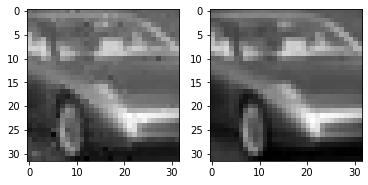

True label: 1
predicted label: 0
Time:  323.3924870491028  seconds
Initial fitness: 
 [-0.6000556099325667, -0.6000050020527312, -0.6000280998781785, -0.6000865713074534, -0.6000836158185141, -0.6000470199505281, -0.600045742321983, -0.6000534602778668, -0.6000373059903121, -0.6000292587791056, -0.6000471537054667, -0.6000712359943581, -0.600061646888815, -0.600155846095368, -0.6000257303537921, -0.6000243847131689, -0.6000490839074175, -0.6000606015083799, -0.6000899583681683, -0.6000204062063182, -0.6000367690181367, -0.6000232251112937, -0.6000097043830881, -0.60013268003811, -0.6000457676271901, -0.6000878027016177, -0.6000643169143577, -0.6000655425944706, -0.6000997639736729, -0.6001489815460195, -0.6000224874432585, -0.6000204513060382, -0.6000640824848567, -0.6000474633601742, -0.6000946724974685, -0.6000997218990421, -0.600058693937076, -0.6000965833071329, -0.6000268162182023, -0.6000245267314392, -0.6000515804651686, -0.6000469819594949, -0.6001187139531927, -0.6000594596654

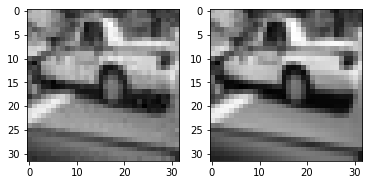

True label: 1
predicted label: 9
Time:  885.75346326828  seconds
Initial fitness: 
 [-0.6000131966914901, -0.6010562342643606, -0.6000703013348844, -0.6027543226693186, -0.6009252568461554, -0.6000276531867081, -0.600044282085308, -0.6006234512416664, -0.6015798660126701, -0.6008282878223634, -0.6001494399565177, -0.6000234960079532, -0.6005055423038034, -0.6002912771399438, -0.6003011724154145, -0.6007978168989914, -0.6000624497345359, -0.6012730300576292, -0.6004315882771989, -0.6001310408561962, -0.6007784742571006, -0.6000760592243064, -0.6000363129614479, -0.6002968432683491, -0.601674246684354, -0.6001566986494277, -0.6007847269904673, -0.600716225383944, -0.6008112816841187, -0.6049518077345165, -0.6015538606912618, -0.6001949738654739, -0.6025390948783256, -0.6000246872116177, -0.6012220240537951, -0.6019670387343707, -0.6010225288106542, -0.6011381200685073, -0.6000664540906414, -0.6004525492528601, -0.6017280558250764, -0.6003740588006005, -0.600170158036586, -0.6024483133210

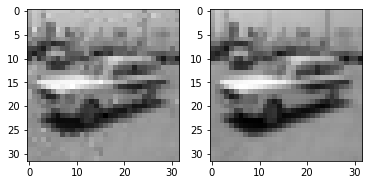

True label: 1
predicted label: 0
Time:  297.24855494499207  seconds
Initial fitness: 
 [-0.600004606953472, -0.600034540302759, -0.6001251154944373, -0.6000536790959964, -0.6000110251287185, -0.6000953699907602, -0.6001708448941669, -0.600076043967158, -0.6001085221576032, -0.6000667252914024, -0.6000456195016497, -0.6000783991221512, -0.6000487998747095, -0.600118490637904, -0.6000318204178999, -0.6000863254200199, -0.6000453733677293, -0.6000640163284416, -0.6000409027691964, -0.6000242559133812, -0.6000938246906307, -0.6000663683621579, -0.6000895005272446, -0.6000784885037787, -0.6000419233544365, -0.6000482428296516, -0.6000430203188378, -0.6000457094241105, -0.6000138701841112, -0.6000042923520753, -0.6000522932033193, -0.6000051262360441, -0.6000777102718653, -0.6000370874364828, -0.6000310109401472, -0.6000519820447837, -0.6001123274837049, -0.6000400626268745, -0.6001351735199036, -0.6001264804739498, -0.6001674319031624, -0.6000581529153655, -0.600061735472263, -0.60009334133

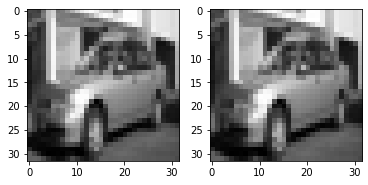

True label: 1
predicted label: 1
Time:  111.04487800598145  seconds
Initial fitness: 
 [-0.5999219799482941, -0.5995841914596245, -0.596292732387441, -0.599325311308149, -0.5997826782090616, -0.5998731191763476, -0.599636333767235, -0.5996679970918932, -0.5997667155680462, -0.5996307212214418, -0.599735603982176, -0.59973418826549, -0.5998379443708957, -0.5990326327403948, -0.59980031185555, -0.6001287832976826, -0.5995478275614836, -0.5998199936102985, -0.5999018174092468, -0.5997764334159551, -0.5994490534806923, -0.5997872842939012, -0.5997215147194046, -0.60018696248253, -0.5999085877140734, -0.5994107480110351, -0.5994102593217525, -0.599826774953425, -0.5996254783412672, -0.5996827849141704, -0.5995297120495306, -0.5994492130209703, -0.6001537940364718, -0.5998055128903252, -0.6005173048667231, -0.599928179583757, -0.5995925532513777, -0.5996546489847911, -0.599502422336206, -0.599614463844464, -0.5994612414451835, -0.5995115513787659, -0.599683068362909, -0.5996236827435626, -0.

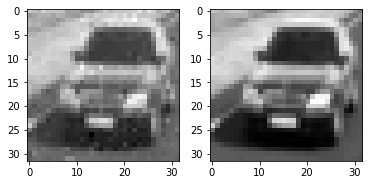

True label: 1
predicted label: 9
Time:  373.82486748695374  seconds
Initial fitness: 
 [-0.6001095798688629, -0.6000203897554063, -0.600074822224496, -0.6001532550449967, -0.6001485023854378, -0.6000498078136113, -0.6001854216243004, -0.6000978659746462, -0.6000180452528255, -0.6001831410156833, -0.6001204221346224, -0.6001314029949771, -0.600114184505219, -0.6000568296582693, -0.6000954294895335, -0.6002752111162504, -0.6002077843211965, -0.6001263438480855, -0.6000559478465275, -0.6000609803712459, -0.6002388561857143, -0.6000318975942194, -0.6002507249038864, -0.6000967029803504, -0.6003297882741687, -0.600165103010258, -0.6001373065311859, -0.6002538051960304, -0.6001623451855485, -0.6001119086512937, -0.6001612357240418, -0.6000561124571154, -0.6000838372547821, -0.600121788709663, -0.6001805270951811, -0.6001776815275983, -0.6000678479582203, -0.6000754597219152, -0.600038504313744, -0.6001682277773064, -0.6000928078640195, -0.600091451339787, -0.6001067000103325, -0.600047450792

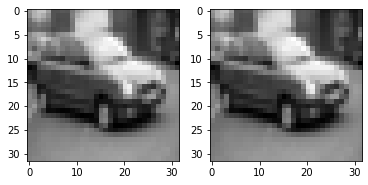

True label: 1
predicted label: 1
Time:  110.74935054779053  seconds
Initial fitness: 
 [-0.6000476447144268, -0.6000408380531612, -0.6002056468220754, -0.6003912697946284, -0.6001434235668476, -0.6003827137114228, -0.6001008527503403, -0.6001167633683823, -0.6003840375986155, -0.6000047695026722, -0.6000369777922412, -0.6001693997315345, -0.6003462956351291, -0.6000622135214043, -0.6004474156866948, -0.6000957571216192, -0.6002187818327528, -0.6000060851573202, -0.6003283785715569, -0.6000963757081628, -0.6002049541684309, -0.6002806245027054, -0.6002080796754641, -0.600113125895136, -0.6003162120379658, -0.6001928405682158, -0.6002722491868773, -0.6001317697704232, -0.6000933804239221, -0.6000966587282074, -0.6001476017887049, -0.6001569861370575, -0.6000652278677097, -0.6000673236960038, -0.6000452773756805, -0.6002153063394536, -0.600071213308295, -0.6000900544798794, -0.6001196282107213, -0.6001238313453814, -0.6001971173624403, -0.60016398117039, -0.6001902392255658, -0.6004808786

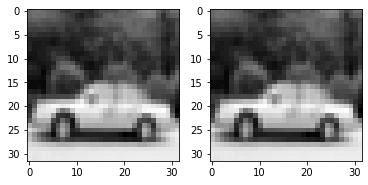

True label: 1
predicted label: 1
Time:  110.89213585853577  seconds
Initial fitness: 
 [-0.5948117945556985, -0.5863367157543589, -0.5951806802638868, -0.5876718254109289, -0.5970179317936267, -0.5928528743036373, -0.5897162632147138, -0.5924968372234207, -0.5934481205155961, -0.5916693290488084, -0.5926039546963453, -0.5985809169080643, -0.5855160938880087, -0.5939531988646942, -0.5942054529160813, -0.5908804635872902, -0.5909110742226987, -0.5876397408276627, -0.594785957836961, -0.5939545031718054, -0.5868048036622154, -0.5807759652586365, -0.5892438241353622, -0.5917970420243189, -0.5902292568847572, -0.5908971588213423, -0.5865415134485338, -0.5928507030157626, -0.5821785767472567, -0.5953663292893512, -0.5887802527358456, -0.5930775835930587, -0.591366092771976, -0.5914537610642443, -0.5837613540590976, -0.5891128479985988, -0.5895593536471934, -0.5746747190150536, -0.5853091835985216, -0.5925155142071119, -0.5915323875652209, -0.5904446815932273, -0.5900601170197934, -0.59350629

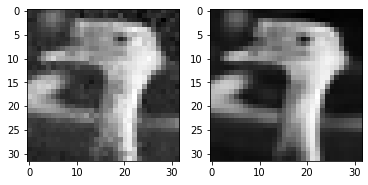

True label: 2
predicted label: 3
Time:  632.1016104221344  seconds
Initial fitness: 
 [0.6002211668414433, 0.5489169615711313, 0.6584237998713818, 0.822317821500285, 0.583389178090912, 0.7216390963954024, 0.6861761480318953, 0.632928020827163, 0.5989349408010121, 0.7156107785684718, 0.7777049902068893, 0.5501790176688759, 0.7239123594186877, 0.6742524753097763, 0.44606805839123076, 0.6878336964812911, 0.6099705795275556, 0.702471294349825, 0.6302513195347391, 0.44383115609950236, 0.5147846253771909, 0.6963537427481155, 0.587626942339332, 0.6846491992087976, 0.591318866696674, 0.7269396189529058, 0.6633857217028983, 0.6416080256680033, 0.6887942040886755, 0.6292061592568887, 0.7596488233472114, 0.637753698725402, 0.42324986360309347, 0.5937053119605267, 0.5238878858494063, 0.7189765038977516, 0.3560273470924183, 0.6916964609721427, 0.6092023332869045, 0.5865546149917149, 0.7018993677564572, 0.6934000212828405, 0.6858788483873961, 0.6178585228883713, 0.7953754872059967, 0.629346240437972

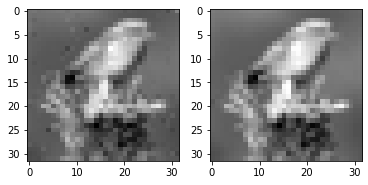

True label: 2
predicted label: 6
Time:  195.12657761573792  seconds
Initial fitness: 
 [-0.047705871890300594, -0.27114523437756155, -0.27803553565179434, -0.28801659953838676, -0.2551500854428463, -0.20236178468254398, -0.18444755329523987, -0.3089580562741059, -0.10025160683439074, -0.20439737980241213, 0.09831781311474004, -0.23489030750945125, -0.1866861568135951, -0.2983036112647207, -0.21050719678608085, -0.3169681450822824, -0.2016210573927523, -0.28446405099964145, -0.2370403788485737, -0.2737626864836553, -0.15265158366681386, -0.2696145736564797, -0.17187444249008216, -0.25657045400515077, -0.23350045837150632, -0.2845013206716015, -0.1495268720613542, -0.1312266624385114, -0.2895148893408235, -0.2625223548774751, -0.20019926199807525, -0.30615140768458954, -0.05711548300284669, -0.21773095189161334, -0.20607391375212664, -0.2864697031369525, -0.2512413519678282, -0.30391098791001875, -0.14546728916419654, -0.2731808952338153, -0.1729137913965093, -0.2941126675512065, -0.2187

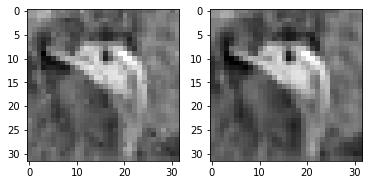

True label: 2
predicted label: 6
Time:  180.656804561615  seconds
Initial fitness: 
 [-0.43458612838009625, -0.15257662448969464, -0.04760254980157974, -0.18336058457797966, -0.5004785134139348, -0.5118486887548757, -0.20100605875962035, -0.19375437174333662, -0.2731644084033906, -0.2661832328009177, -0.15289461939262416, -0.08800841097059436, -0.18100199323521324, -0.40583098874632273, -0.24956867336098632, -0.14157921579485255, -0.17624110843991841, -0.15256946579787733, -0.19003957670595367, -0.1579012799204135, -0.2714782887261944, -0.28629978585272786, -0.23663172334637633, -0.38395026308768415, -0.16156233190757416, -0.3265215001385816, -0.1627731000219672, -0.20113910826523135, -0.35313260880314856, -0.292011286962335, -0.2712228036352976, -0.3542848229784986, -0.15530630746267066, -0.09035883930429384, -0.3118041829628204, -0.022932888982013316, -0.17344709872611402, -0.06228561299364102, -0.11416390971054838, -0.2898918420012859, -0.1806172131249043, -0.33171421093768405, -0.2

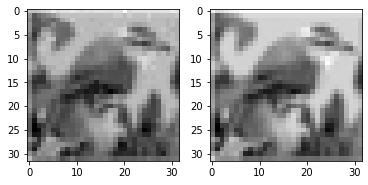

True label: 2
predicted label: 5
Time:  258.5101408958435  seconds
Initial fitness: 
 [-0.5999341692516291, -0.5997237502302245, -0.5999670920235274, -0.6000217217789865, -0.6003554152763617, -0.5999742469224454, -0.6001986124304487, -0.6007752343034813, -0.5997408378324625, -0.5999351628812738, -0.5997338282384824, -0.6004696847351059, -0.6008341257001188, -0.5998816354430883, -0.5997553065945846, -0.6001862422485424, -0.5999379664551853, -0.6002975401604013, -0.5997559260209444, -0.6004462984886471, -0.5998899008250164, -0.6003110208940456, -0.6001180677889998, -0.5999806849419473, -0.6002652546408976, -0.6005013474420294, -0.6001195689584198, -0.5998989659678162, -0.5998534907564894, -0.600695626025458, -0.601362399963106, -0.6000020283722617, -0.60078252335192, -0.5998465368760485, -0.600223797007255, -0.6003161438176982, -0.5997851480310643, -0.5999993510753956, -0.6003294890719606, -0.6004027402368791, -0.5999719430079671, -0.600245059054682, -0.5999741710981149, -0.6003372584049

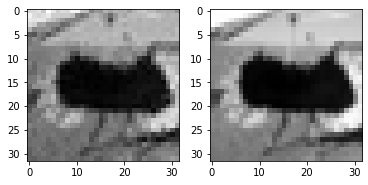

True label: 2
predicted label: 6
Time:  1301.3755037784576  seconds
Initial fitness: 
 [-0.07901444193815071, -0.25367510724612663, -0.36966694702208347, -0.14522720520691856, -0.09741147314653481, 0.1688358145110408, 0.05036955036132407, -0.038626231682609674, -0.022484872115090593, -0.19185137119011497, -0.18492527563234404, -0.218935439460155, -0.08148043374371855, -0.2229876349188975, 0.06582999604010115, -0.14869543829661522, -0.12432325990998258, 0.05852102556637323, -0.17086282657587107, -0.07467332044700503, -0.2977563277798675, -0.26050145331121444, -0.05891521226026744, -0.008680053148047817, -0.07798197626978193, -0.030999270486105568, -0.1887465753053781, 0.14286901770027388, -0.20122777111216406, -0.0321809078014291, -0.07585991776252016, -0.004069844119849009, -0.21734157780005028, 0.45679081815876293, -0.1795919843774474, -0.1863930174765021, -0.19971856318772208, -0.3970658444919839, -0.10010593539081558, -0.0030764366072275062, -0.11596974678298663, -0.0438844024189973

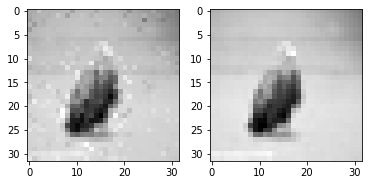

True label: 2
predicted label: 6
Time:  259.92306566238403  seconds
Initial fitness: 
 [-0.5961904310768618, -0.59646151534821, -0.5952375833393091, -0.5970890542017243, -0.5957967891754038, -0.5952993683025353, -0.5958814937449615, -0.5937086450932436, -0.594482350807185, -0.5928828479381116, -0.5964454903839354, -0.5905612007696271, -0.5950503835323916, -0.5957782152201255, -0.5965913821679292, -0.5965452716890782, -0.5938720564272162, -0.5970762558860678, -0.5955423451642422, -0.5961115499536599, -0.5968586765943787, -0.5957369460599555, -0.5950357570868386, -0.5938059028772079, -0.597405259960389, -0.5971929710366038, -0.5923159708676755, -0.59587253966125, -0.5947989114151814, -0.5966219032488027, -0.594603278066214, -0.5959130461174893, -0.5955811681550575, -0.5967862343594016, -0.5952504905174201, -0.595729585728346, -0.5975839624943731, -0.5958915674764615, -0.595229985518632, -0.5945353140741859, -0.5954552359550841, -0.5904563753411542, -0.595903954413448, -0.5942378371083951

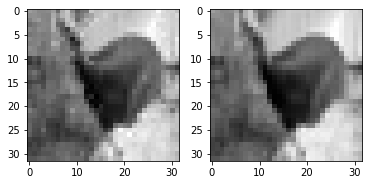

True label: 2
predicted label: 4
Time:  285.1108248233795  seconds
Initial fitness: 
 [-0.05372428243036936, 0.01919314113521753, -0.13353749403816423, -0.13399835929525775, -0.08769848014142756, -0.08847937635238001, -0.16964943215865408, -0.32684681037858865, -0.4192932063868394, -0.25721871394079693, -0.18709428457771904, -0.16462112167814924, -0.1143691373905465, -0.12338363627009621, -0.10667178895155849, 0.09262809095184155, -0.4222180037093791, -0.19372573388122136, -0.034028755417197326, -0.07358487923308762, -0.2166541888042205, -0.07024455450227585, -0.1209485737352411, -0.21732826869979935, -0.19875563241343502, -0.14777173194852286, -0.29587746330046993, -0.15704095146694988, -0.05834068321407379, -0.06923274106092081, -0.0018549408466625172, -0.20512407786657305, -0.13767753672054406, 0.11807673708557738, -0.11396133544167436, -0.10275963381613157, -0.08654136159311793, -0.2610667644689203, -0.21898459908601042, -0.13471308058528977, -0.10896255504548896, -0.11886048850185

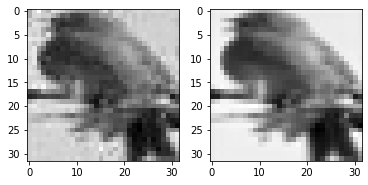

True label: 2
predicted label: 6
Time:  867.2691411972046  seconds
Initial fitness: 
 [-0.5714792503332301, -0.5789774077975255, -0.5915635638091824, -0.5790410311227232, -0.58190974798823, -0.5796204329195564, -0.5899574232110046, -0.5766045607077702, -0.565734112160595, -0.5792883571655292, -0.564389319919413, -0.5844097016347446, -0.5820271674601887, -0.5890251738879635, -0.5705234540277078, -0.5772207831178955, -0.5753309470448296, -0.5817534492000256, -0.5597107488759582, -0.5877479798602889, -0.5704170369862249, -0.5433967344827088, -0.5851976625672939, -0.5844265080633047, -0.5820192110468531, -0.5539223354755695, -0.5780413288087421, -0.5846354745720654, -0.5677006635231141, -0.5930352848159617, -0.5699227646017804, -0.5819988131350982, -0.5864425393259733, -0.5773419532835786, -0.5868045854737182, -0.5783533632393825, -0.5837401712556577, -0.5614881494264014, -0.5749299747841076, -0.5810245570930986, -0.5820087717223351, -0.5902645496825456, -0.5858534948642175, -0.57565305812

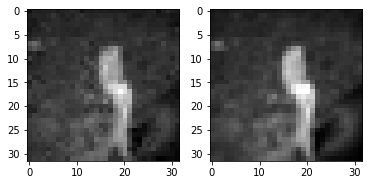

True label: 2
predicted label: 3
Time:  502.9854464530945  seconds
Initial fitness: 
 [-0.5715513566587579, -0.558920363109948, -0.5566884706144348, -0.5474188477308719, -0.5628889315709175, -0.532950526902149, -0.551166194761787, -0.5700132986308264, -0.5535529596019529, -0.5711861611003447, -0.5612817876312052, -0.5575483511597625, -0.5809547493757947, -0.5583466426806084, -0.5614701754038522, -0.5662155167445042, -0.5362201439748785, -0.5387965069728851, -0.5480051452987833, -0.5586412860149558, -0.5578026820551545, -0.5483872644214903, -0.5580898837944558, -0.5611419374481583, -0.5654780042732357, -0.5635025504045519, -0.5628046468738188, -0.5615910500690374, -0.5624918600429795, -0.5680282266351733, -0.5558929354849504, -0.5596499186283066, -0.5690189113340351, -0.5325027250237161, -0.564034795490173, -0.5658696787746792, -0.5698374551850276, -0.5613738657894655, -0.5527654057386306, -0.5679214098050291, -0.5597905152237359, -0.5532313813884288, -0.5633834175594814, -0.55515899110

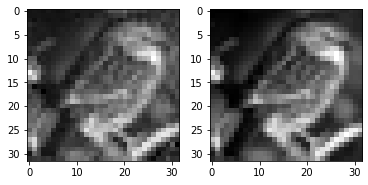

True label: 2
predicted label: 6
Time:  994.3955435752869  seconds
Initial fitness: 
 [0.8827923193841882, 0.8676215677328016, 0.8933882018637149, 0.9003512107243671, 0.9052545684722513, 0.8663130193385726, 0.884268729499105, 0.8977445619995446, 0.716155870517643, 0.8540592813025271, 0.8477386063231923, 0.8162941736947072, 0.8693480321534272, 0.9320306654208043, 0.9167193008821349, 0.8556868955430188, 0.8626745364164594, 0.8930826800457631, 0.8690792923343098, 0.889249983204211, 0.875480343631409, 0.9062343103437127, 0.8287035989917394, 0.897560461216212, 0.8329053200210488, 0.9003308906475682, 0.868964576480891, 0.8846925117913829, 0.8558939647469761, 0.9065914626518509, 0.8406962389514292, 0.8746659995587357, 0.8799923510743536, 0.854397111451658, 0.7925272348225672, 0.9006913240923947, 0.7087630290663833, 0.8672935823791174, 0.915108911267335, 0.8340510225092201, 0.7599495277349505, 0.9056536632059267, 0.9117652812648376, 0.9017166445742313, 0.9004751727847105, 0.9002126436748599, 0

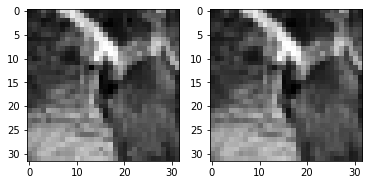

True label: 2
predicted label: 7
Time:  189.22887420654297  seconds
Initial fitness: 
 [-0.6176422558459476, -0.6051020349093033, -0.6122637768255295, -0.6196731559701841, -0.6038398508417198, -0.6224244456401142, -0.609808433991382, -0.6059658020660013, -0.6218380125628765, -0.6198875758013018, -0.6064377488844545, -0.6226785136976885, -0.6301656804864189, -0.6244561022751851, -0.6256977936344683, -0.6083823056260964, -0.6143810836534332, -0.6184356852920255, -0.6045759611896693, -0.6146220544428035, -0.6188381635595177, -0.6078861545550881, -0.6169363296251311, -0.615196860275921, -0.6237400913053223, -0.6192854188349629, -0.606736435911899, -0.6206497065543058, -0.616357616482694, -0.6125334383401109, -0.6078797829386314, -0.6114563340575798, -0.6137294474476332, -0.6260883187298689, -0.6207716491598785, -0.6083303604221967, -0.6122836718386792, -0.6098909670751471, -0.6085543974189962, -0.616831717551485, -0.6328222161266572, -0.6154415441704878, -0.6170392594092843, -0.60796026119

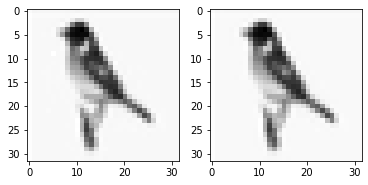

True label: 2
predicted label: 2
Time:  111.90768480300903  seconds
Initial fitness: 
 [-0.6003536009726873, -0.6001291615280807, -0.6007654210921725, -0.600065626179705, -0.6002903377721867, -0.6002373131174781, -0.6000864827391019, -0.6002631310916915, -0.6005091328303976, -0.6000531483999799, -0.6001004612596414, -0.6000751678116523, -0.6008029585714029, -0.6001504302310334, -0.6001742552837479, -0.6000779604951849, -0.6001293661712583, -0.600094019209371, -0.6002170066870935, -0.6002350369224121, -0.6001871137461882, -0.6001964565453953, -0.6000411599782732, -0.600408677246392, -0.6001240565934733, -0.6006445480493595, -0.6003162007410593, -0.6002716713494349, -0.6007752323122288, -0.600547038500728, -0.6005773974646138, -0.6001065177047047, -0.6001379957262167, -0.6003526977045005, -0.6002453624656969, -0.6000091346708284, -0.6004997847145719, -0.6004333747270179, -0.6002320586659522, -0.6000602601618354, -0.6000333723125413, -0.6001213742828357, -0.6003803288045028, -0.6002580184

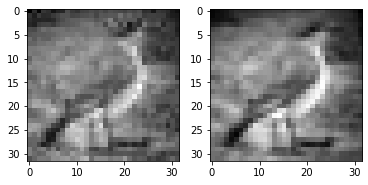

True label: 2
predicted label: 4
Time:  762.2919428348541  seconds
Initial fitness: 
 [-0.6015988312839873, -0.6005576221611458, -0.6034601931156856, -0.6010087042798216, -0.6001038708306273, -0.6003029655841767, -0.6006375991081857, -0.6022225666866855, -0.60125685390588, -0.6020671717044306, -0.6012095078300002, -0.6007449557307217, -0.601064650669674, -0.6003148014258379, -0.6001439694265174, -0.6019212172335077, -0.6003258666360168, -0.6024613524090253, -0.6002238207813031, -0.6025068624817603, -0.6007846334927982, -0.6024730103940718, -0.6024868459149291, -0.6013151330836205, -0.601252300265245, -0.6028634069020276, -0.6021857744180474, -0.6058907459957276, -0.6015668802642146, -0.6013660359310066, -0.6016266362133862, -0.6031095314311887, -0.6016116187778509, -0.6026523308445315, -0.6011702567782208, -0.6005769425519869, -0.6015617295803137, -0.6003812315230912, -0.6037785357534079, -0.6009298406398758, -0.6004495604549025, -0.606212322052883, -0.60448696035869, -0.60190320819374

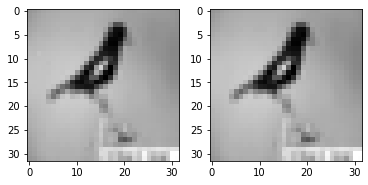

True label: 2
predicted label: 2
Time:  111.53241419792175  seconds
Initial fitness: 
 [0.9914130802773864, 0.990853375664094, 0.9892161478089188, 0.977151406185014, 0.9893283796569263, 0.9890989463022624, 0.9896634239414868, 0.9898523353971704, 0.9860093821697192, 0.9764447419919678, 0.9891933836452085, 0.9843974715453527, 0.9872681546755125, 0.9825530144573482, 0.9926036015557308, 0.9881747532272791, 0.9885590434195005, 0.9842443304289036, 0.9852261972323804, 0.987500619176223, 0.9883571348673159, 0.9857727674949534, 0.9884542756858968, 0.9894877838163006, 0.9910015252199968, 0.9643107698654924, 0.98563703561985, 0.9892176078336881, 0.9873455816739498, 0.9899136802207005, 0.9898445001179025, 0.9812209878979216, 0.9851273068360054, 0.9943233588997139, 0.9879285917635028, 0.9848898786126152, 0.9850453754422809, 0.9848594420227667, 0.9944925034104359, 0.9842528885325669, 0.9890582811912301, 0.986198830781684, 0.985287626331244, 0.9889863128701206, 0.9927154623019867, 0.9868415617118216,

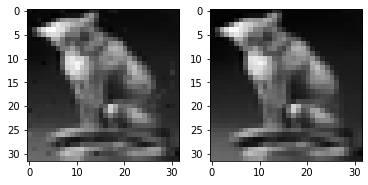

True label: 3
predicted label: 2
Time:  163.3441286087036  seconds
Initial fitness: 
 [0.44020355082929374, 0.4711268429573888, 0.13934573722813817, 0.3965844290347774, 0.4265875604349718, 0.19818607780622194, 0.37633151733002773, 0.3003006180094828, 0.2074710966309709, 0.29457497729786164, 0.4596207352792741, 0.09285965358636976, 0.1349818683408317, 0.16671010623361066, 0.4701517700482946, 0.34263076101723866, 0.3365202517924011, 0.2527343275017763, 0.27242857205114196, 0.36192605426867985, 0.3327432082552386, 0.19980223363208652, 0.32675699129638824, 0.2825724129053172, 0.27924356727456107, 0.44892779519602133, 0.5123785895948458, 0.28152460533958806, 0.2670126075590119, 0.13063822604507125, 0.46810092002182435, 0.22939584300789675, 0.44971677688391754, 0.4289873071630661, 0.2083507617596989, 0.17249004804766163, 0.05123988819239342, 0.22246034641758422, 0.0651798802437539, 0.4502654610263809, 0.31946639493745854, -0.16033348782633194, 0.07009542700587584, 0.35921172846332894, 0.2400

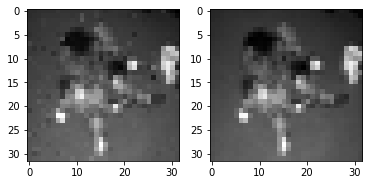

True label: 3
predicted label: 0
Time:  218.53177952766418  seconds
Initial fitness: 
 [-0.2113888703780199, -0.2967654067611941, -0.12764423945452058, -0.22964454711495047, -0.2396454114045104, -0.26093252781997345, -0.30060117248715623, -0.27995727612201027, -0.256631874647609, -0.30424633900627684, -0.3215876392822864, -0.2570406049861212, -0.2347851494353725, -0.29801865973384745, -0.2834429892974163, -0.28217911450534927, -0.34545034044503087, -0.2890232469459951, -0.2860149482662112, -0.30846540380009746, -0.1976674205735622, -0.30430603620007135, -0.07947045595008029, -0.30907760485085467, -0.29929682623314324, -0.32619128695905775, -0.28149801407482666, -0.26386668495255255, -0.2668088125658238, -0.27937699369396174, -0.2548014869765033, -0.26497297338774, -0.3057631402178785, -0.2913073612446406, -0.24462460203744046, -0.2692735320226126, -0.2785250680585694, -0.24572986479638273, -0.341503542969073, -0.2623307853777094, -0.22501444925098296, -0.4504836639645714, -0.2629953977

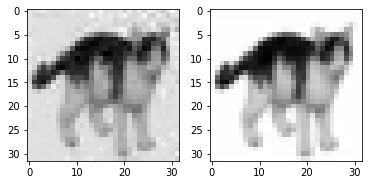

True label: 3
predicted label: 5
Time:  698.3832168579102  seconds
Initial fitness: 
 [-0.5618803279394449, -0.5454911273206758, -0.5739672828286237, -0.5618838340859825, -0.5689163874996581, -0.5600094381931182, -0.5637653030370358, -0.5623838506833665, -0.5721017887465618, -0.5556806559291855, -0.5599943014947266, -0.5629550336470172, -0.5668200778457634, -0.5664786646563794, -0.5627430191127467, -0.56242725864768, -0.5622627387410708, -0.5650368645770265, -0.5482720272843632, -0.5663534308239078, -0.5570719064257281, -0.56352452191577, -0.5550824343670264, -0.5694787681014298, -0.5840682490395313, -0.5734272025302182, -0.5636200065259946, -0.5521149899087738, -0.554903097429547, -0.5635586038586362, -0.5402001206508334, -0.5674772206158574, -0.5357185416680237, -0.5400999618099782, -0.5596027689096704, -0.5753162107747634, -0.5131571525735338, -0.5657306210672393, -0.5766709679202502, -0.5611354546444218, -0.558033473142804, -0.5644293056038151, -0.5618192878409721, -0.5601943039171

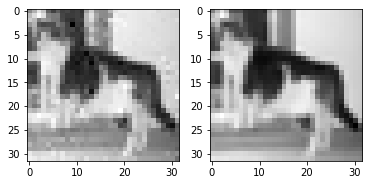

True label: 3
predicted label: 7
Time:  441.5478050708771  seconds
Initial fitness: 
 [0.781220803023398, 0.6134382228325523, 0.5831388234069421, 0.693283903782185, 0.5472484302358827, 0.5221197611223105, 0.7150411175889142, 0.7059128188108766, 0.7166588285914564, 0.6906245649984317, 0.5658007059090716, 0.74316938911393, 0.6484147069228944, 0.6068791079051689, 0.6617542060002416, 0.6674569693284969, 0.5242396510642588, 0.6237979027291203, 0.6622238426984453, 0.6897145520754895, 0.7984403298682409, 0.6628627785828966, 0.48909329654608735, 0.31780330710769167, 0.6816074299292725, 0.47425027697991334, 0.519373069543037, 0.8014222715424575, 0.7099117804822832, 0.7906003430217803, 0.6089076678826457, 0.5449277580719769, 0.6840365651652394, 0.7466704355190081, 0.6460935767047412, 0.7078785950868506, 0.6491201319003604, 0.6486265188823479, 0.6222375790551817, 0.6469398360604716, 0.7440713424238758, 0.7953380224867792, 0.7211040849242343, 0.49547921149594487, 0.7484591632202837, 0.688951317708

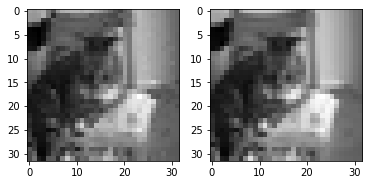

True label: 3
predicted label: 2
Time:  211.1345100402832  seconds
Initial fitness: 
 [-0.21364899110546193, -0.21425364940077932, -0.24682299741103142, -0.22493205146018944, -0.12314185685208398, -0.22425659665330977, -0.28411595076704343, -0.2259277280837724, -0.28622711586496136, -0.26713916368557106, -0.2592597560114636, -0.21651815293526733, -0.28084085435932843, -0.2752633895464184, -0.27379711197792567, -0.2637016547751256, -0.18205890491620114, -0.2589158627596291, -0.19220665297656758, -0.2728056911685335, -0.3170004220729411, -0.2571307659825251, -0.2930124684693009, -0.13671131915752918, -0.30021248700146064, -0.21929706248556924, -0.19506643016847747, -0.267544957136691, -0.1853062625200771, -0.2598155359509341, -0.28491767878923, -0.17584507295158863, -0.2501524520134534, -0.24718032296504017, -0.23366578479351652, -0.2925041842177596, -0.30422736082358937, -0.21765486659792893, -0.19724710139239165, -0.22870262769628358, -0.2624793572558972, -0.3075982515412853, -0.119065

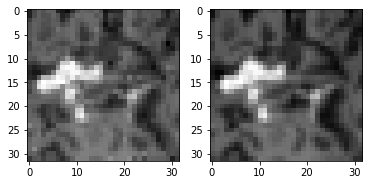

True label: 3
predicted label: 6
Time:  256.3610942363739  seconds
Initial fitness: 
 [-0.5827495954221211, -0.5877128391723936, -0.5820196711497333, -0.582749574334473, -0.5831143053696799, -0.5820043580374266, -0.5856553706824282, -0.5862206213358823, -0.5804520620462533, -0.5812933009640662, -0.5847978211682365, -0.5904386524354427, -0.5852836878809203, -0.5844019396176168, -0.5670191306673695, -0.5780586281237194, -0.5892621700699733, -0.5867979622759868, -0.5876343764607503, -0.5821809561987836, -0.584490226186523, -0.5903995756461111, -0.583183852455522, -0.5861595783347002, -0.5832783818694646, -0.5803104277362044, -0.5819398425086774, -0.584702501486889, -0.5836535957794433, -0.5861819332802451, -0.5779438281000996, -0.5806513499413396, -0.5936299727614558, -0.5878961967151232, -0.5859687234660301, -0.5772354766686751, -0.5835712242801812, -0.5836658257921745, -0.583892229135541, -0.5819139414926229, -0.5847486096968375, -0.5823703133113352, -0.5864572235784902, -0.586649649744

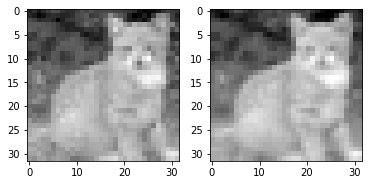

True label: 3
predicted label: 5
Time:  538.2908384799957  seconds
Initial fitness: 
 [-0.29717754794565754, -0.36815582207042535, -0.3736236005510031, -0.3986180083226135, -0.30512931031565205, -0.31918394597604116, -0.28984110711952427, -0.33510710688249773, -0.3494186992128547, -0.38245975384383724, -0.3406295512750707, -0.3787351316142378, -0.3707668542664285, -0.3397378443989207, -0.2778063831161477, -0.32858228374601167, -0.35133500375741095, -0.35269039709486694, -0.17100910080056259, -0.3366082958496809, -0.3737974429786915, -0.29659798896992856, -0.32863477459405716, -0.3499602900002128, -0.3653933355836187, -0.395148750237972, -0.4358964450913312, -0.2283306872787519, -0.37258515216925797, -0.4171703596990721, -0.26993436912582447, -0.11462192025607754, -0.339876335029751, -0.056704931011076376, -0.3109436410130769, -0.3465730387286393, -0.1840232888340468, -0.365405611257122, -0.36082030053953773, -0.1768522957770975, -0.13949268032631673, -0.3100216485876073, -0.20478351971

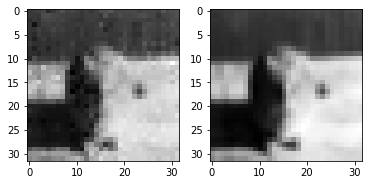

True label: 3
predicted label: 7
Time:  545.8686895370483  seconds
Initial fitness: 
 [-0.5891568044946187, -0.5313643061411139, -0.5871049332274278, -0.5579121166321723, -0.5839105893049592, -0.5965136709142155, -0.5923097297150806, -0.587059149628364, -0.5822703304574273, -0.5680078230653498, -0.5712061455653864, -0.5862401230090026, -0.5809842444372881, -0.5749281594875372, -0.5839684876788722, -0.590238280189163, -0.5861761598242602, -0.5864352886411666, -0.5864299614201107, -0.579548439490629, -0.5849200921096128, -0.5854626975779624, -0.5818368999656709, -0.5873448776009336, -0.5877505659502746, -0.5791141079177725, -0.578210624523256, -0.5802247025773983, -0.5389227085477679, -0.5660790166279512, -0.5800973251735211, -0.5766735800817548, -0.5850183250574229, -0.5845951503770815, -0.5418914149014794, -0.5835677832160753, -0.5855194526378124, -0.5822451397485306, -0.5813375624451862, -0.5795634081872197, -0.5977703275684765, -0.5827602923689994, -0.5817062433901734, -0.57187399617

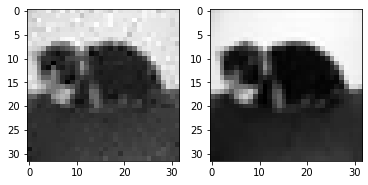

True label: 3
predicted label: 5
Time:  534.7948729991913  seconds
Initial fitness: 
 [-0.5330692630276859, -0.49937895992980197, -0.5507086823463441, -0.5663688260211566, -0.5448897371517821, -0.5554487466555403, -0.5578124927891921, -0.508580776830987, -0.5297417616383722, -0.5440071730396132, -0.5216541338266067, -0.5338208734725329, -0.5255927819364281, -0.5502748255575516, -0.5422509859430198, -0.5638279065050804, -0.5398000563428196, -0.5250122091498646, -0.5025249472872485, -0.45191363294610176, -0.5297504142516412, -0.5446684471391956, -0.5507025791782555, -0.5278593323523035, -0.5359055630925347, -0.5566996283272735, -0.5338436814562169, -0.5212253440928402, -0.5608453400968095, -0.5398979202740452, -0.5290326651153139, -0.5512037867151274, -0.5374884636387329, -0.5478798945582801, -0.522334248443999, -0.5247143935809923, -0.5333145637462927, -0.5478134705935394, -0.5154772658567511, -0.5526824229818801, -0.5588419255243604, -0.5515119817380282, -0.5375217706441247, -0.5451124

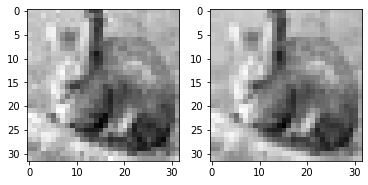

True label: 3
predicted label: 2
Time:  533.7786867618561  seconds
Initial fitness: 
 [-0.5063522604205638, -0.5054111927034942, -0.504167096074283, -0.4979201530621006, -0.4879365979670844, -0.5019767994546868, -0.5064321198444679, -0.4683960533681535, -0.5418340463689288, -0.5098877572984764, -0.5130171932928544, -0.5190647948251395, -0.5164925044990507, -0.5245021422386383, -0.5232714904415244, -0.5032406401192449, -0.5063070065994761, -0.528664936514261, -0.5116498507108415, -0.5014791439748176, -0.5159121503662278, -0.5093267585343649, -0.5080730229627468, -0.5041965426872892, -0.48498684261997427, -0.5259303970732179, -0.5118525528868169, -0.5103233054464017, -0.5084483188259125, -0.5441904302536592, -0.49422666225051776, -0.515013862513299, -0.5323141413707575, -0.4671051997136677, -0.515313460328194, -0.4567372716526211, -0.5047637728566976, -0.48312351743397514, -0.4922087354668394, -0.5091067042727149, -0.49272160187545233, -0.5153712260608875, -0.5442278432261921, -0.4798911

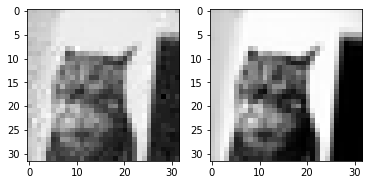

True label: 3
predicted label: 2
Time:  490.0114302635193  seconds
Initial fitness: 
 [0.6734016560357452, 0.6977763721453979, 0.7035353071185148, 0.6189082677230427, 0.7410976530875624, 0.617294056001878, 0.5775229136239277, 0.6714716435623942, 0.6037341009019792, 0.5737949545606749, 0.6838958196387365, 0.7402557260245186, 0.7256640126351594, 0.7384435313922654, 0.7041874926900555, 0.7259278194892365, 0.5566925354331731, 0.5940114437437811, 0.6178869445346244, 0.5993057842218307, 0.597726869472688, 0.6961663321877449, 0.6623424059121831, 0.5720235901953907, 0.7010675940060045, 0.7242376945827047, 0.6912331274589829, 0.6579599140736263, 0.687709194887536, 0.5512316604805831, 0.6599833621011242, 0.68885965568654, 0.6235700983851279, 0.6940869320397507, 0.7078712084809731, 0.6550336694826729, 0.6601721239147204, 0.706468628106641, 0.6580478416573521, 0.7119683780884057, 0.676895506759864, 0.6539587100785681, 0.5893580678465523, 0.7268100724161799, 0.8218292342666835, 0.6749534477084878, 

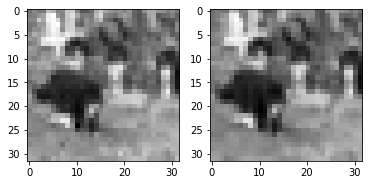

True label: 3
predicted label: 2
Time:  242.57392048835754  seconds
Initial fitness: 
 [0.3266907650729156, 0.40282481094057565, 0.2834009486996264, 0.4498169100625191, 0.37428650442880573, 0.3556482679035874, 0.2098407225238586, 0.23676985196179154, 0.3003184414664257, 0.24794162530475264, 0.39556664163687005, 0.3427724903980568, 0.395434301038021, 0.45646760887963256, 0.48213735693739435, 0.42562153993581076, 0.26580019520188297, 0.5955825422239804, 0.37889965267232717, 0.32936254591607345, 0.387686952820553, 0.18996004640793016, 0.3410439491069003, 0.2342457602716283, 0.5253032667460246, 0.43200459710789796, 0.31962524927701863, 0.4956617658533349, 0.2348169064006668, 0.19453415340235716, 0.3224806263464141, 0.31842042681936594, 0.3614688863753747, 0.38562597815054706, 0.25855328117940535, 0.2977661917310578, 0.3192361438573425, 0.382066001369991, 0.271361448864216, 0.1806285041462709, 0.26748708745970934, 0.26130112391730465, 0.264392178530208, 0.24411249921071806, 0.30696457088048

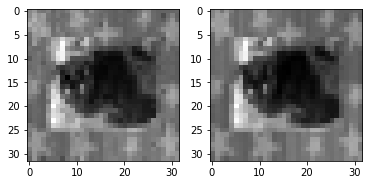

True label: 3
predicted label: 5
Time:  253.8302354812622  seconds
Initial fitness: 
 [-0.6002895768344663, -0.6002464573357645, -0.6002531500435107, -0.6000289154488476, -0.6000867407931458, -0.6003743647442401, -0.6001196988623536, -0.6006264197385047, -0.6002634591332721, -0.6000937406679521, -0.6000507054845929, -0.6001561586145436, -0.6000843524872507, -0.6001920392369196, -0.6000831709124412, -0.6004113581778869, -0.6000746251947922, -0.6000935811864166, -0.6000146474207416, -0.6000255411468127, -0.6001012100186984, -0.6001454489326294, -0.6000633630679868, -0.6000073588353303, -0.6002982374132559, -0.6003051749246224, -0.6004934118164634, -0.600241398391936, -0.6002900197801487, -0.6000820231511002, -0.6000450977165204, -0.6002710671000162, -0.6001417266824249, -0.6002926066348379, -0.60001363592291, -0.6003636986144907, -0.600222600046254, -0.6004262923553663, -0.6006195529003445, -0.6002295098984164, -0.6002866859224346, -0.600041742347462, -0.6001407197653944, -0.600128197389

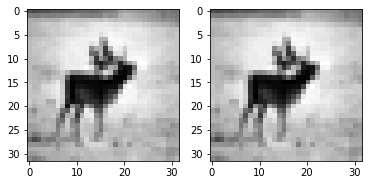

True label: 4
predicted label: 4
Time:  111.67697358131409  seconds
Initial fitness: 
 [0.6976102320112121, 0.693063724434109, 0.7730927495896307, 0.6121371328781182, 0.6029572220263218, 0.5336631005968482, 0.6705378713973846, 0.5907288227318386, 0.6412091502490049, 0.6770284132647597, 0.640579209799034, 0.6596123664557645, 0.4646836075765627, 0.714938735744488, 0.7084968124839576, 0.7378367688604228, 0.6372193570243404, 0.6454824650820341, 0.6893465700084873, 0.7921462706735, 0.7416348398927523, 0.5328027727322663, 0.6635047779017604, 0.1760374819253467, 0.6170700192273673, 0.6387704174923884, 0.7185928926621903, 0.7161413488049219, 0.6230897619308925, 0.7208505685757869, 0.6894581160183637, 0.6963890865326534, 0.7170399694892872, 0.6279749435464043, 0.6485600004878598, 0.6558420828536865, 0.49815974878293645, 0.5602349112687626, 0.6914370077150971, 0.7629056778693846, 0.6485130739029928, 0.5505526815163096, 0.555922486336149, 0.6286270753692448, 0.4732491689035432, 0.708408605454972,

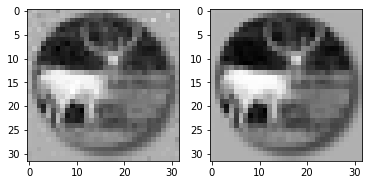

True label: 4
predicted label: 1
Time:  360.3824725151062  seconds
Initial fitness: 
 [-0.40125045671345, -0.5108644766357404, -0.4734238462305004, -0.4809181529448828, -0.43347234506707094, -0.4213556842864937, -0.4797349672792409, -0.524321113661141, -0.4528183638171698, -0.4670964066400545, -0.318878312072826, -0.4654879759787985, -0.4382033848357014, -0.4904834373952963, -0.3356571614706794, -0.4565528609042363, -0.3760786514220382, -0.2700908628909653, -0.4890385860620196, -0.396768640870068, -0.4258739455774292, -0.46019468975338323, -0.477238118473024, -0.44156959007481117, -0.38061483933093687, -0.4545457501721428, -0.4486236131454694, -0.47029013342252235, -0.45656419854657404, -0.38992826710811723, -0.4827318134522349, -0.4349119497046784, -0.3901928630764831, -0.3888993728037532, -0.304362171649906, -0.4666271271437385, -0.3229135033450198, -0.5011738018039864, -0.5429416713861522, -0.4565981926967231, -0.438448253152652, -0.3352403272620289, -0.38608989951758627, -0.4655435

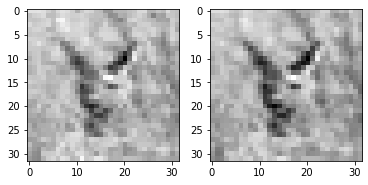

True label: 4
predicted label: 2
Time:  260.4663441181183  seconds
Initial fitness: 
 [-0.5958841224774448, -0.5951954837925928, -0.5934772497901057, -0.5857209422035995, -0.5946690043904046, -0.5916865883853084, -0.5933124880325599, -0.5937835844830361, -0.5943719697906188, -0.595788863647613, -0.5937760785835141, -0.5936666971621618, -0.5965829313197981, -0.5979511604628132, -0.5900191095201205, -0.5923111060627366, -0.5945143121883478, -0.5914464802265474, -0.5913390976173608, -0.5868933729300041, -0.5904091192207191, -0.595571829071301, -0.5871763220507424, -0.5951509405517151, -0.5941640393833175, -0.5917311540379776, -0.5927991341976336, -0.5972982994854318, -0.594520433851643, -0.5948772945119748, -0.5945060246824541, -0.5924874991001672, -0.594054591735993, -0.5976527873603106, -0.5920652315641897, -0.5936728643683097, -0.5947857284481823, -0.594688764550484, -0.5914681982867835, -0.5957523534750633, -0.5954990135748749, -0.5904631692900901, -0.5943219309785428, -0.587257683492

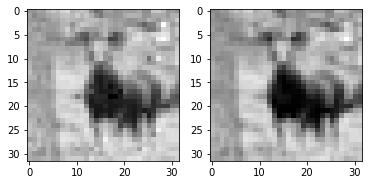

True label: 4
predicted label: 7
Time:  230.89008021354675  seconds
Initial fitness: 
 [-0.5413375670901623, -0.533531510416198, -0.5304076150707072, -0.5442918156359494, -0.4901320488495402, -0.5194078853438747, -0.552795510248592, -0.47377358148870663, -0.38435202678853086, -0.5300071956727898, -0.411379737433931, -0.540057158996148, -0.5650038260206521, -0.49564077950702395, -0.5257661405179865, -0.561505310564731, -0.5078290625210414, -0.31829561962056074, -0.5066961681006299, -0.4614591132014848, -0.5114209106380472, -0.48666045310156697, -0.5223375015712659, -0.5666349637780497, -0.5452917896396717, -0.44920369907103874, -0.4965685273716974, -0.5383724068190274, -0.4510224620438113, -0.5474591802474085, -0.48069234339927075, -0.5530690383364085, -0.5652287898999402, -0.5492093271270203, -0.4881287166497741, -0.46364451526898476, -0.5320174505530957, -0.5053446889953441, -0.5147645825106507, -0.49987611735755244, -0.578589189021245, -0.4804245683455325, -0.5405689204132886, -0.483

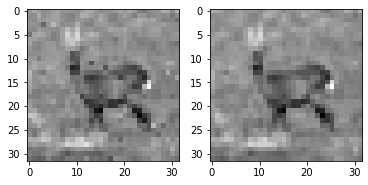

True label: 4
predicted label: 2
Time:  145.66892337799072  seconds
Initial fitness: 
 [-0.5927571214543411, -0.5953267917265368, -0.5963240333272766, -0.5936285888402335, -0.5974762218208939, -0.5922934225419701, -0.579960636350229, -0.5942131037890612, -0.5890977554125256, -0.5937756531711871, -0.5945191993304155, -0.5947311250035331, -0.5913234099003389, -0.5967449943698467, -0.5952545761565795, -0.5956541088565397, -0.5960437270294856, -0.5938817056706478, -0.5851547494767027, -0.5799582436946381, -0.5886299901045077, -0.5958544551049161, -0.5926662096131804, -0.5966266311380235, -0.591461703817015, -0.590643836275057, -0.5953770663280898, -0.5960955454410712, -0.5964830481062111, -0.5922607309845286, -0.5805367449843761, -0.5946657203018377, -0.5921681181809685, -0.5945188427393501, -0.5946536337388996, -0.5904088348801458, -0.5941350446602632, -0.586641139290484, -0.5963244670918657, -0.5938288302459692, -0.5940427514658511, -0.5914804620095564, -0.5939316149726136, -0.5894622408

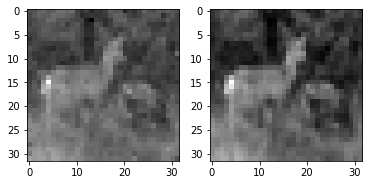

True label: 4
predicted label: 2
Time:  306.0273115634918  seconds
Initial fitness: 
 [0.36012734066494434, 0.33124327571917145, 0.43689784189583036, 0.3986141231292563, 0.1698801999933658, 0.24318905273673702, 0.1016708054609829, -0.19309248635025028, 0.5072158015869481, 0.39866630310587337, 0.4432979411556347, 0.46557033725358843, 0.30471037613975105, 0.18772798256686712, 0.16878174632974444, 0.30395390899178854, 0.15337814487340257, 0.27252975154193726, 0.6765319660949771, 0.5806469708413906, 0.3845188671909615, 0.402492576082195, 0.40714230439681176, 0.572204919786474, 0.4532830479866714, 0.390322227371079, 0.0632013431634007, 0.41769177459196244, 0.36537911603490214, 0.2894441904211126, 0.22838885661711858, 0.08283948105196233, 0.35556793268452513, -0.20855339622282618, 0.039025948416856915, 0.20764909879492838, 0.3890254162304335, 0.22445306221028524, 0.49455682893204955, 0.4259103729487558, 0.279607723034507, 0.015357907175608282, 0.3248508703656312, 0.5357700685718196, 0.433762

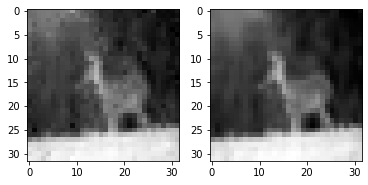

True label: 4
predicted label: 3
Time:  365.5999755859375  seconds
Initial fitness: 
 [0.9929272441727215, 0.9932845034255762, 0.9958257609957144, 0.9956537976050248, 0.9971028526158467, 0.9969101090170678, 0.9968176774124657, 0.9940978102801322, 0.9943214800727932, 0.9965086446286445, 0.9972110394230248, 0.9943224125067387, 0.9970404401748241, 0.9968083146474473, 0.9973617019883646, 0.9953832579850969, 0.9980729862876646, 0.9952924441534328, 0.9972740776146845, 0.9933127721417495, 0.996957590509755, 0.9967560905980077, 0.9961903232471221, 0.996381989250354, 0.9973229017458037, 0.9960123682110951, 0.9958966236983743, 0.9951922384866052, 0.9961960995666067, 0.9932458999035401, 0.9976577694195088, 0.9852090438340382, 0.9970520723304349, 0.9958773203949312, 0.9930849219678534, 0.9973955044170659, 0.9934850878663031, 0.9933969778952658, 0.9869926090866363, 0.996317068634319, 0.9944765382457307, 0.9954561442342813, 0.9963877319706855, 0.992823763599325, 0.996271168149232, 0.9907488300605879

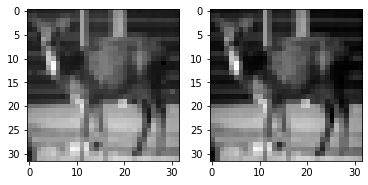

True label: 4
predicted label: 7
Time:  135.0682988166809  seconds
Initial fitness: 
 [-0.5728714202676669, -0.5611262177118552, -0.5627750672579573, -0.5710904448834212, -0.5780147384072677, -0.5674010283171167, -0.5739412868796465, -0.560242777676389, -0.5618953867949716, -0.570368291806049, -0.5558438277001586, -0.5637441394058367, -0.5572611264924849, -0.5700609293704546, -0.5572736115913624, -0.5602654692567549, -0.570013652122434, -0.5630041323649584, -0.5600871729761823, -0.5746640562645963, -0.5788326438984375, -0.5728919414216043, -0.567090817195326, -0.5738984957837282, -0.5688288710100142, -0.5657445167483427, -0.5698234302990782, -0.5753401866861764, -0.5498925805690442, -0.5683523484447396, -0.552962500790626, -0.565405815415259, -0.5614729647339717, -0.5405833311028787, -0.5627407879746968, -0.5364761726799345, -0.5855753888569055, -0.569530258407055, -0.5604442901082023, -0.5639262732239616, -0.5593814497057144, -0.5754859074553331, -0.5736513462631665, -0.57008584471532

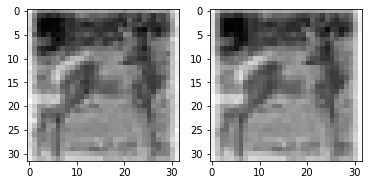

True label: 4
predicted label: 7
Time:  365.6878070831299  seconds
Initial fitness: 
 [-0.5947196650708817, -0.5920446656447769, -0.5940376224282118, -0.5888624434593769, -0.5951030247132862, -0.5938512023959094, -0.5938542376434651, -0.5924517246448916, -0.5924598532970564, -0.5948768722763362, -0.5945886776756054, -0.5935165473288155, -0.5958800946633283, -0.5897379341047467, -0.5962030417659274, -0.593245983476484, -0.5960161687404103, -0.5915243233795476, -0.5938156011560084, -0.5942459691690356, -0.5937439746284927, -0.5947379855473536, -0.5950410577172568, -0.5947611975815534, -0.5886155234103678, -0.5935466419993449, -0.5925638183235699, -0.5940746099054556, -0.591789572615757, -0.5927552391716634, -0.5946581861297892, -0.5903479458061754, -0.5949265151327585, -0.5918826544445566, -0.5946533630784074, -0.5942156203293536, -0.5920492845386708, -0.5951586439926201, -0.5866421391158636, -0.5944002121604971, -0.5939588044663981, -0.5926712593374996, -0.5959477933730365, -0.593710554

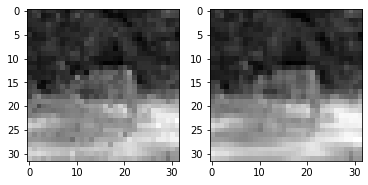

True label: 4
predicted label: 2
Time:  259.9688379764557  seconds
Initial fitness: 
 [-0.02162449421468743, -0.07493763621020308, -0.14580952472843778, -0.07443698362860193, -0.0923072659839902, 0.15864200618102509, -0.11224806899707332, 0.14203615442102407, -0.15191536305538267, -0.20214568714166156, -0.015839485010154142, -0.027453409485686947, -0.33888285858372436, -0.1195508077679231, -0.12984094786717815, -0.09177660793401857, -0.11018178027807024, -0.5196472030704675, -0.1435009854086684, -0.07358156178600558, -0.24009763162993938, 0.024305691829558995, -0.17052372672703542, -0.2886400479476956, -0.16482474536592792, -0.087234277849258, -0.09584102092818586, -0.15330057830164587, -0.1675011106273666, -0.009965868654662785, -0.02255604105167311, 0.419437668248148, -0.29604331880416074, -0.09742117035480152, -0.25945320006442335, -0.03939240948191439, -0.1510716063881094, -0.11669205606419536, 0.11538770931509613, -0.1875954879100053, -0.12504621586701747, -0.007430811535792448, -

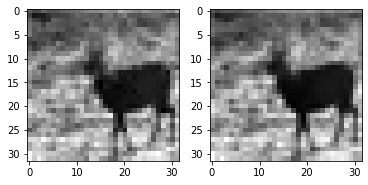

True label: 4
predicted label: 2
Time:  332.29955554008484  seconds
Initial fitness: 
 [-0.5966902569584891, -0.5959157755792593, -0.5953012023691181, -0.5951666954532527, -0.5966781457524917, -0.5921897420126809, -0.5906379141112843, -0.5913111126013325, -0.5963658435025805, -0.5940558136691125, -0.5895199515740072, -0.5936414016186732, -0.5967532324493617, -0.5948646844250249, -0.5931566679269891, -0.5948119481352008, -0.5948407805828084, -0.5980493888665238, -0.5935405101492945, -0.5939986244349369, -0.5964268080141669, -0.5966452078630784, -0.5917403008282415, -0.5953368663841788, -0.5954815941730106, -0.596579677332467, -0.5945449974499112, -0.5944368757677453, -0.5928514753931946, -0.5948342502171081, -0.5953868512818159, -0.5952962662137231, -0.596835410562444, -0.5931318586201375, -0.5955583951005039, -0.5913556995014848, -0.5921735453284582, -0.5953695910885886, -0.5967185734065971, -0.595163993030948, -0.5943657543533849, -0.5952910752185536, -0.5969573083636048, -0.596872505

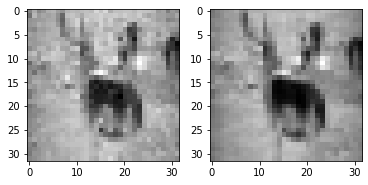

True label: 4
predicted label: 5
Time:  497.716735124588  seconds
Initial fitness: 
 [0.3694509263604746, 0.41300690752696867, 0.31358408377543134, 0.38119752774483884, 0.5304572966197917, 0.41499976957912854, 0.42733859484544434, 0.3721251680534984, 0.5307401991983363, 0.4497622361216593, 0.6152761412130132, 0.39248044350764255, 0.3591429079299737, 0.4597671526023665, 0.3861702100671186, 0.3367210944157405, 0.4524232360600558, 0.4780368702647572, 0.3854739929072275, 0.42509359222664056, 0.4355849940064759, 0.3294603526465705, 0.3102296892617964, 0.38777087478969197, 0.43640337091344195, 0.4095470713458193, 0.41425350383694814, 0.3616651372867728, 0.35911304151500645, 0.3448640613080465, 0.2353799495991934, 0.4192094855786239, 0.40574686779141705, 0.4227319773659072, 0.3554204159975327, 0.2963928855673174, 0.5076199299912331, 0.33974380688777034, 0.46290938165068357, 0.4009764781491555, 0.3340437154469307, 0.4497657879499272, 0.3281635794256185, 0.4484718365948198, 0.521343289739157, 0

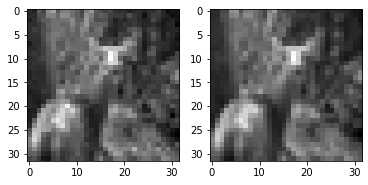

True label: 4
predicted label: 2
Time:  294.35400462150574  seconds
Initial fitness: 
 [-0.2934247152976829, -0.0003711025319773076, -0.23549494857845737, -0.35801852654577815, -0.47116540939338125, -0.40898699209423217, -0.2859897694091703, -0.14210367436254756, -0.17320329496299502, -0.1000035914786217, -0.019052056938904327, -0.22503213534994618, 0.060916082382402315, -0.3960802741099726, -0.21172041897338797, -0.46550445056789425, -0.40747315920400523, -0.3320304238061407, -0.22391670850913262, -0.16388904058506693, -0.23986407198987156, -0.0901718174649982, -0.14874486820337582, -0.4581918106867849, -0.07535067940988546, -0.3269723423977031, -0.22049354509450877, -0.26551349485654396, -0.15423340788386972, -0.16390701672643074, -0.14663115284077577, -0.14950025128672606, -0.1842186262851458, -0.25448190226304607, -0.3578507626042692, 0.06539781934890831, -0.30584353858405755, -0.41083544992698645, -0.27614998830536525, 0.2557680500276446, 0.052729969156676465, -0.14466277658891843

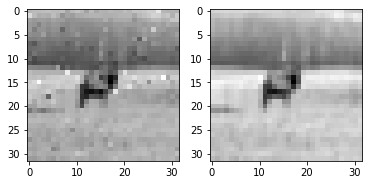

True label: 4
predicted label: 0
Time:  223.39112854003906  seconds
Initial fitness: 
 [-0.008537117321896853, -0.263989330576778, 0.039348788090740355, -0.12834109338974453, -0.1961336494400479, 0.10137290078992311, -0.2161338913740171, -0.23694826544917333, 0.012371432827874035, -0.09924478782200655, 0.01612242041880882, 0.011885418306742251, 0.11909265540585726, 0.1474819756240594, 0.06953837537957414, -0.006806717893100445, -0.25580930147439784, -0.07439434348621077, -0.07586816625985085, -0.2284550374533063, -0.20712674478187265, -0.303913904573966, -0.33706427673844797, 0.10511699797156118, -0.20744496377995264, -0.14329999833612986, -0.07405411527150885, 0.009896902706022587, -0.16050746405958466, 0.07982085207926047, -0.09970941818035953, 0.07998588259295689, -0.07007442077507225, 0.0422303223019673, 0.4818655721667078, -0.23044027952343998, -0.07776586490297122, 0.003226236907768243, -0.05054804976512811, -0.05438851615015017, 0.0798110601958685, -0.08554225808552701, -0.01858

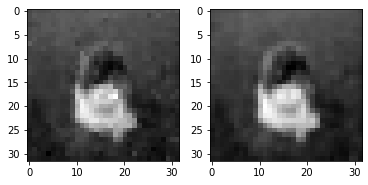

True label: 5
predicted label: 3
Time:  246.39528799057007  seconds
Initial fitness: 
 [-0.5864495326096895, -0.5797903105417315, -0.5878074915181484, -0.5890914629705479, -0.5857761782995639, -0.583402599202159, -0.5873576466639171, -0.5858068368909017, -0.585750072420396, -0.5852062298125145, -0.5863919348291387, -0.5793180856642726, -0.5814995085108247, -0.5863773018276297, -0.5832905899573986, -0.5884094240576391, -0.5880311233034937, -0.5536401929805733, -0.584195615892857, -0.5817140953471398, -0.5902917474904608, -0.5816709055153557, -0.5914412330755914, -0.5835455238436082, -0.5857493504202101, -0.5798694513087411, -0.5881234402666259, -0.5805096128460265, -0.5783635907818433, -0.5861414375676284, -0.5828617437224726, -0.569877836417346, -0.5893974177037492, -0.5871727709924686, -0.5876176502064656, -0.5796791470205043, -0.586051624274702, -0.5875983863027274, -0.5934858001789969, -0.5867115285828464, -0.5842281109742573, -0.5904679388272758, -0.5820701879780484, -0.58942344837

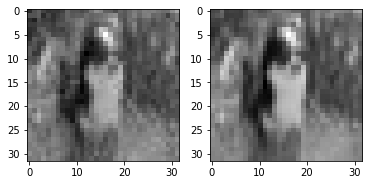

True label: 5
predicted label: 2
Time:  895.9857630729675  seconds
Initial fitness: 
 [-0.42487191958502923, -0.4493517018027686, -0.3874480151044692, -0.3706731276288222, -0.37991327255870144, -0.4463993158887448, -0.4406344531649876, -0.28213722060918345, -0.4801764408365926, -0.47073544542224255, -0.48515488626778625, -0.5061070217829171, -0.43089431677634416, -0.4602473252199311, -0.4169316718650047, -0.4057380693688258, -0.4854842030564579, -0.5024259980189926, -0.45028365304216467, -0.38493918846790465, -0.38609585054461293, -0.3977409536909895, -0.4691413609411581, -0.4943487946530823, -0.3523026861716728, -0.4589529757773406, -0.47947133772592565, -0.3918537703508379, -0.4176512968782714, -0.4287509731032404, -0.5392329725562475, -0.3977913318425377, -0.42846933845042445, -0.4575734618085297, -0.3820601957583535, -0.4823113581095098, -0.19506796717519098, -0.46880505096048014, -0.4509710372539475, -0.40725383136593263, -0.3921692086361769, -0.47507233001157645, -0.4234922040127

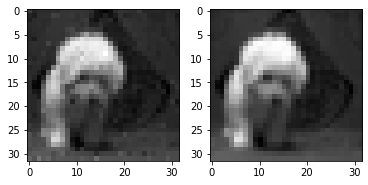

True label: 5
predicted label: 2
Time:  227.50044870376587  seconds
Initial fitness: 
 [-0.585099099954165, -0.5716420269698079, -0.5862671593351195, -0.581298716205128, -0.5708653854587628, -0.5863016571493734, -0.5768057129757145, -0.581137483086128, -0.5871048427266476, -0.5854168710046382, -0.5820314300768215, -0.5788126904516107, -0.5712468197849491, -0.5833695091870448, -0.5579517502608123, -0.5786693255889237, -0.5793294545244023, -0.5799165914547716, -0.5768979699169922, -0.5843303011586367, -0.5754482825703032, -0.5771025394108629, -0.581606362736356, -0.5675988396155346, -0.5809116005272312, -0.5773620817345311, -0.5821656276131197, -0.5762243452590322, -0.584863763289381, -0.5863539745941442, -0.5848760151413096, -0.587800160968184, -0.5842290787102196, -0.5880289811504812, -0.5878866008574553, -0.5797759444310167, -0.5821692826280128, -0.5850866845037057, -0.5877730238863792, -0.5523066161520228, -0.5850209255406496, -0.5870582537698363, -0.583283655832868, -0.5817192304127

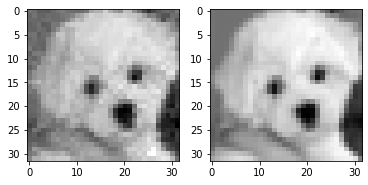

True label: 5
predicted label: 3
Time:  1013.7173058986664  seconds
Initial fitness: 
 [-0.07839524031097067, 0.1702626079993847, 0.25654081117235017, 0.07865450910401978, -0.24921901253395462, 0.2625993800365415, 0.07537283257653755, 0.054708041859175854, 0.2928596323260918, -0.02475011551891723, 0.14025504731916563, 0.16602567922671602, -0.09041987077970268, 0.1295044463020004, -0.027712847594355106, 0.19181239427909944, 0.3422698111360897, 0.09459718473775415, 0.26023421654746415, 0.06496455986274832, 0.02767619055521106, 0.10352665913447459, 0.04050398371563979, 0.3158455362640651, -0.01805808222501007, 0.15174094384721998, 0.075379416524681, -0.1846400275112484, 0.1728790972111814, 0.17516595940835586, 0.09177640522438792, 0.07757930470472056, -0.014200381154352987, 0.11858282578771104, 0.023617694279235463, 0.17681811254595223, 0.05406487062972101, -0.014500795727852567, 0.15088679161294716, -0.023429607170504713, 0.11092927562441218, -0.18674058970497287, 0.16396033574361912, 0.

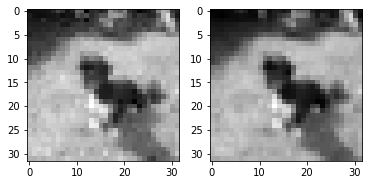

True label: 5
predicted label: 2
Time:  414.53676772117615  seconds
Initial fitness: 
 [0.01884737385029575, -0.025757667461810685, -0.20672038832345718, -0.19305021565521197, 0.052532488716232034, 0.007711126034503357, -0.03963215412318055, 0.3005835530155571, -0.07849032411167653, -0.1785167915881838, -0.08328899607942769, -0.13124137207689826, -0.11652153329429307, 0.06357476770522796, 0.03537242013913042, -0.2867507296584253, -0.15981995518937464, -0.14028422057665924, -0.023389967122057848, 0.06903256101577951, -0.11082734776312703, -0.03388859420299528, -0.0012462310035986357, -0.1904509446371561, 0.024704701033172738, -0.09686065053670045, -0.1618832663828671, -0.12459438448388155, -0.09567019608264843, -0.1699967319414055, -0.029935754522171454, -0.16528454652818253, -0.10593398760537728, -0.11757454062228065, -0.04448214839394679, 0.05239664036871164, -0.0070885761827357285, 0.019630681466812072, -0.0597657483664219, -0.15676353290797673, -0.05110160289275273, -0.1810040098203

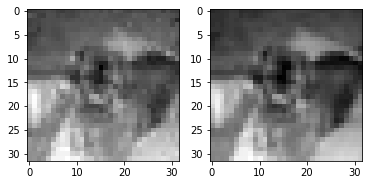

True label: 5
predicted label: 6
Time:  321.63234758377075  seconds
Initial fitness: 
 [-0.598742122944406, -0.5996090762440162, -0.599168489417432, -0.5989938349510893, -0.600883883921965, -0.6011349182752488, -0.6000674315934321, -0.599021385890766, -0.5997227775442853, -0.6008267078493874, -0.5987999244615715, -0.5983268086490002, -0.599346187578814, -0.5989035790355768, -0.599425835561482, -0.6007796524938388, -0.5990149358475559, -0.5986252852573706, -0.5991786873375632, -0.6011544882720556, -0.5999121718750647, -0.5989966309060551, -0.6004828466355521, -0.6002445600496504, -0.6021511756740212, -0.6012293990664428, -0.5992195078272777, -0.5992274982428335, -0.5999102888850876, -0.5991269742171128, -0.5992246585669128, -0.5992835997081112, -0.59793675633734, -0.5980499420199412, -0.5981515884797529, -0.600061229737777, -0.5987657104848816, -0.5987495244397943, -0.6002088619270965, -0.598265439133831, -0.5985761008691377, -0.5983448633939874, -0.6017031679226716, -0.6035100056918427

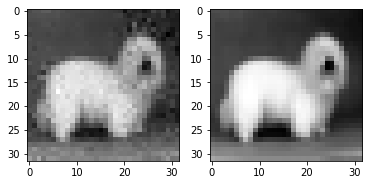

True label: 5
predicted label: 3
Time:  564.6553642749786  seconds
Initial fitness: 
 [0.7404235678680308, 0.7296073444342673, 0.7371508842132063, 0.7764395988281441, 0.7509528487862867, 0.6883017852634904, 0.7011568016587242, 0.752024550473594, 0.735780255316024, 0.76304547169155, 0.7579449814152425, 0.7882931903872298, 0.738495145703887, 0.7621103659876171, 0.7994272918707694, 0.7863753496560738, 0.6893346257804334, 0.8001270616333576, 0.7153458733093443, 0.7122031198134194, 0.7602925750766859, 0.7369246615502941, 0.6725989259968221, 0.743093454407525, 0.6920644550212269, 0.8196670573549834, 0.7437622903343939, 0.7515476463201705, 0.7508405986391176, 0.7070446839280975, 0.7318969392949545, 0.7252149578684555, 0.7280563027018523, 0.721463400013302, 0.7821622648907607, 0.6932096190464812, 0.7304038350130739, 0.7315997032661123, 0.6826884068222623, 0.7256144964897042, 0.7142882414564332, 0.7577261991249867, 0.7375139280759475, 0.6993049702647788, 0.707263977657155, 0.73342431389173, 0.7

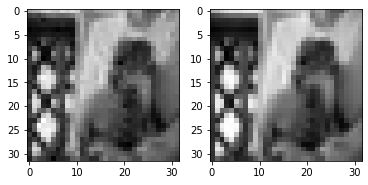

True label: 5
predicted label: 3
Time:  486.3543779850006  seconds
Initial fitness: 
 [-0.3291691649880861, -0.388864109085131, -0.3223364233835533, -0.34850825489396686, -0.36525276674622614, -0.44149797716386396, -0.360207184282198, -0.33546770364347434, -0.30498371007166925, -0.29826799036148066, -0.3349955160554291, -0.3380811714456716, -0.40033063347525755, -0.3893589046171897, -0.35034973798587654, -0.3295919312855497, -0.32068484317347323, -0.35014144037571693, -0.2396867128327802, -0.3886929618055217, -0.3841466829884765, -0.28995661323180444, -0.20643003217059094, -0.3845427180093769, -0.4292422349500348, -0.3482588699177266, -0.4011457167577741, -0.31749267721936614, -0.3379135510990483, -0.42163003807301686, -0.3584031030682555, -0.42859137629416966, -0.37981610139970867, -0.48268269483814263, -0.2649407259122295, -0.2457738468766147, -0.30045805826734984, -0.3479565149239998, -0.45348052250217236, -0.2949698430246357, -0.3935912929244416, -0.32084289749601425, -0.3805025553

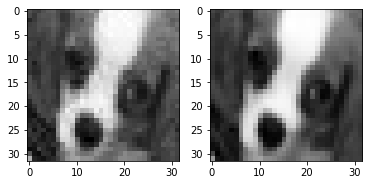

True label: 5
predicted label: 3
Time:  9251.166460514069  seconds
Initial fitness: 
 [0.10861850439665542, 0.20731116720088705, 0.14018321218927837, 0.14216708201951597, 0.22425269003593012, 0.1502030796730561, 0.1526715027298956, 0.22124101239891145, 0.14298989848848426, 0.2696522491470398, 0.2863264674426174, 0.09197535273487437, 0.12606015037805315, 0.1137738702405209, 0.1688402901272764, 0.22131612515133564, 0.18457519692879937, 0.12277685709800917, 0.2517221050221635, 0.11319105902215215, 0.1848565569567488, 0.2797860029182065, 0.1837011259226204, 0.08375107204163315, 0.2013914466036874, 0.05984037728528169, 0.2514782420957681, 0.24475375354262086, 0.18494700939242947, 0.1748635295350829, 0.37425960452791424, 0.21339822126713884, 0.25084702567431627, 0.15642212427572813, 0.21183202907693807, 0.16759674691683674, 0.19486979063802215, 0.40203497099596264, 0.29865015614524737, 0.23175731181163117, 0.2404901523692729, 0.1732478718732474, 0.19956221943639, 0.22827437355025404, 0.11456

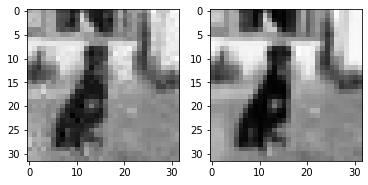

True label: 5
predicted label: 3
Time:  823.612756729126  seconds
Initial fitness: 
 [0.5403924381759383, 0.4099438291404237, 0.6427578976563062, 0.4937822600897481, 0.4688508246597395, 0.561159757463109, 0.5830363265372542, 0.47942448849267966, 0.5500502353845103, 0.6111310451438455, 0.5290595699041012, 0.4963244738014802, 0.5089776057213421, 0.5323608860150852, 0.5030529413645984, 0.6205305724848299, 0.6284403533928902, 0.5807375030653755, 0.5442228319227124, 0.567499898249499, 0.5498065896709465, 0.4865646737069532, 0.5934473324690754, 0.5491888397350765, 0.42252518847378356, 0.5147835093216545, 0.583865158346507, 0.48046837922953817, 0.5516845822240123, 0.4761112726139816, 0.4896290730612581, 0.46861738029525596, 0.5613966409699502, 0.6731855154257828, 0.5544046571413342, 0.5444902488808478, 0.5661880774358837, 0.45752708445710794, 0.5245543181441383, 0.5271697117335278, 0.40862952885949755, 0.612032766022114, 0.5724380400504454, 0.5757652076697121, 0.483359859998619, 0.60924905710

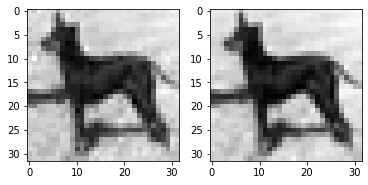

True label: 5
predicted label: 7
Time:  580.7877223491669  seconds
Initial fitness: 
 [-0.6000923256159796, -0.6001006860899057, -0.600109108818214, -0.6002996460976389, -0.6002520261139161, -0.6006969234532853, -0.6002111519248359, -0.6000513513149847, -0.6002048023135718, -0.6003751528146288, -0.5999956859114961, -0.6002385168165387, -0.6000518156171587, -0.6002851403606085, -0.600306643273847, -0.6000625278902874, -0.6004020328801565, -0.6002984975450694, -0.6004300612441116, -0.6002190400554246, -0.6000201812482026, -0.6000902234200028, -0.6000194078431176, -0.6002877893857751, -0.6002387509294385, -0.601001103956439, -0.6007433815459076, -0.6000913843844933, -0.6005327281630196, -0.6000287566577378, -0.6003292898288969, -0.6001330173708146, -0.6001964432466116, -0.6004359942777485, -0.6002113686767617, -0.6002557761009435, -0.6002745340534086, -0.6000744583814922, -0.6005192784520742, -0.600092937094357, -0.6001054772781791, -0.600035332976307, -0.6000121390915959, -0.599995889692

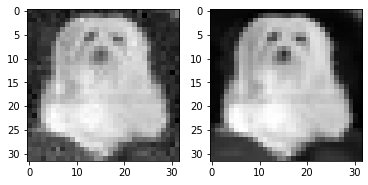

True label: 5
predicted label: 3
Time:  856.6640796661377  seconds
Initial fitness: 
 [0.4060116894781617, 0.32450764709527863, 0.38379318262524603, 0.3496560098662077, 0.259479014429463, 0.30766561402382175, 0.3461296373233065, 0.3773689969375187, 0.2952778483934009, 0.33089188363876154, 0.36569424241017645, 0.3297226568190949, 0.4974891227193908, 0.2196471676358109, 0.3322791110159079, 0.250021384196657, 0.2207425287663211, 0.41432930869014684, 0.38908114820858275, 0.35735132655835894, 0.30646660637943224, 0.29820881892659823, 0.3142832647940275, 0.3110602313330516, 0.3381403503703021, 0.30379369916059007, 0.3321962649496856, 0.3239470376719331, 0.26509557535733286, 0.3480158263349383, 0.23827337925120115, 0.3529613280800249, 0.3301762547407924, 0.5235807976544384, 0.3689282333005741, 0.3522528711255593, 0.35583951558747706, 0.45499112532721664, 0.33427965352961775, 0.3043947657078522, 0.31782118241534063, 0.301860600828028, 0.4338419256652598, 0.30013648681764316, 0.3156568505818332

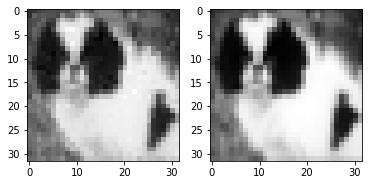

True label: 5
predicted label: 3
Time:  485.0829110145569  seconds
Initial fitness: 
 [0.5289447511841046, 0.3302776094365054, 0.40782951443465165, 0.582536087037091, 0.6405207711282848, 0.40344948492414445, 0.2991256999025643, 0.43027335300458, 0.3290029512345942, 0.3398941502131947, 0.6724280088084287, 0.49799049757043384, 0.4373988187819671, 0.6491635343394621, 0.5732083817569336, 0.3446568737651301, 0.3155922678541532, 0.8483186309023556, 0.5232940526153109, 0.23242584497059202, 0.5968704654053725, 0.3954368909897248, 0.3933247444663831, 0.4811595604846788, 0.5042078265036465, 0.40888715457433417, 0.3636283683917804, 0.40014217567337074, 0.5233686615221722, 0.3733903073478285, 0.4983842111370287, 0.43506278693989475, 0.41617891724375056, 0.4307890143594869, 0.21103679349062032, 0.3831166378624527, 0.5420204925118827, 0.39153941980714535, 0.4771295868691732, 0.4318543880195129, 0.3554814806058536, 0.4339232884410061, 0.5666855054023757, 0.40493348004623764, 0.2868319730674585, 0.290

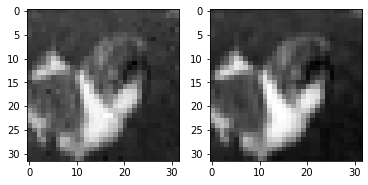

True label: 5
predicted label: 3
Time:  391.21793484687805  seconds
Initial fitness: 
 [-0.6002022517023116, -0.60005360236321, -0.6001551666472102, -0.6000509496625102, -0.6004603926761412, -0.6001451527932902, -0.6006220950126364, -0.6001593550639197, -0.6001592567765394, -0.6000126315108747, -0.6002621231169619, -0.6000946371139546, -0.6001492803970632, -0.6001213219245543, -0.6000875714321248, -0.6002316442170339, -0.6001054107536836, -0.6001097149763843, -0.6002857959568999, -0.6003661825194473, -0.6003126176229199, -0.6002370078809398, -0.6002048315551471, -0.6005483553288355, -0.6002798244621985, -0.6002170087723757, -0.6001470762965139, -0.6000086601599348, -0.6001550459592883, -0.6003165375493779, -0.6002608826691807, -0.6002673728626896, -0.6000601455660894, -0.6001832185020325, -0.6003333116702628, -0.6001643934957958, -0.6002624221805173, -0.600033041864815, -0.6004984294216775, -0.6001453927295028, -0.6008640811046361, -0.6003804990650289, -0.6001359800542888, -0.600240760

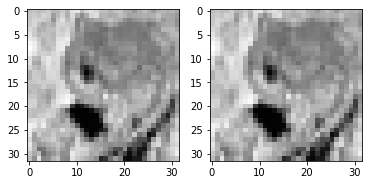

True label: 6
predicted label: 6
Time:  164.6100149154663  seconds
Initial fitness: 
 [-0.546730613092201, -0.5148502127680074, -0.5556853151486236, -0.5387175534288474, -0.5398621303532603, -0.5499125014342565, -0.5514441938126551, -0.564295962985134, -0.5560669735173981, -0.5675056231700276, -0.5423610819403262, -0.5608775809425068, -0.5754935496548373, -0.5437380740162151, -0.5376013283536514, -0.5582446054871225, -0.5648123899936394, -0.571127899569555, -0.5383756812050378, -0.5419385999507658, -0.5519896487000437, -0.5443574885270809, -0.5426833883387137, -0.5548016160045032, -0.54962769280098, -0.5422103758310023, -0.5364231220548583, -0.5388344289962835, -0.5502223205434235, -0.5547114121866572, -0.5717766885530061, -0.5517381313411792, -0.5639143071888619, -0.5149259783734863, -0.5524251061765812, -0.5441890895874689, -0.5579225597712097, -0.5590748106397733, -0.5089436695297207, -0.5160582295874371, -0.542906743777329, -0.5482207102735042, -0.551833810397041, -0.54751826065853

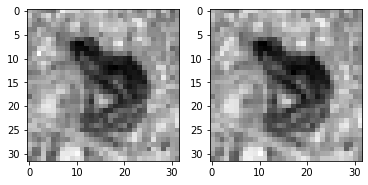

True label: 6
predicted label: 2
Time:  565.8323912620544  seconds
Initial fitness: 
 [0.5048687734086781, 0.5890173783456107, 0.6193714061966838, 0.5704230784857043, 0.5451050017240574, 0.5528245753461524, 0.5230947370112748, 0.5627384998851446, 0.6654284638356901, 0.5186320133679029, 0.5752684090814177, 0.5348525319086368, 0.5824147301445846, 0.5098770573366505, 0.5285965915109136, 0.5139483020781677, 0.5040142383597958, 0.5883891763994402, 0.5615877688177886, 0.8005200133951318, 0.521920585749469, 0.6674700119065831, 0.4842464172587703, 0.5209242293902906, 0.5974045997929548, 0.5622953133161328, 0.5176026081483991, 0.5230506144369865, 0.5892085569701745, 0.5551443137871587, 0.6177760312547427, 0.6340170314611868, 0.5744675309964131, 0.5471432518002523, 0.5404405956302916, 0.6255364046257375, 0.5384409016128571, 0.5880310149335528, 0.5029637410763428, 0.5691391847595644, 0.7945415876629142, 0.5710410872038943, 0.576492416726962, 0.5134179394231844, 0.5131946733015469, 0.5299223301250

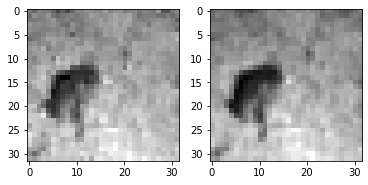

True label: 6
predicted label: 4
Time:  510.1631360054016  seconds
Initial fitness: 
 [-0.5994876695547338, -0.5999255649151423, -0.5996313755143565, -0.5999304263773242, -0.599627708186987, -0.5991632102162484, -0.5996490243835064, -0.5995445340047589, -0.5994250663680023, -0.5998709744190202, -0.5999223313097136, -0.599924332852659, -0.5997232290843948, -0.5997570332478921, -0.5995143275926902, -0.5994453191413973, -0.599524168757284, -0.5993818775392487, -0.5993660746326289, -0.5996801527258344, -0.5995425284341411, -0.5995828237861478, -0.5999393551499755, -0.5993457961861783, -0.5997450058585712, -0.5996889602787407, -0.5995092013655439, -0.5995700907977662, -0.5995628599525544, -0.5994951282482495, -0.599624168529172, -0.599637114125434, -0.5995185831405465, -0.5995782332949778, -0.5998033394367255, -0.5994930360868443, -0.5998356580609379, -0.5995139203407502, -0.5995738690688712, -0.5991467845455615, -0.599634057975924, -0.599819904352708, -0.5997210519295413, -0.59975952372792

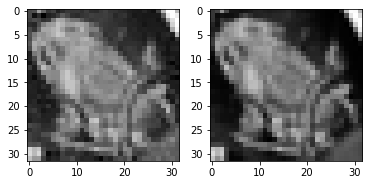

True label: 6
predicted label: 2
Time:  1134.419552564621  seconds
Initial fitness: 
 [-0.6072390335012257, -0.597338159990469, -0.6052423045719997, -0.6003677985597843, -0.6107318969054184, -0.598590539757743, -0.5878931207616837, -0.6040032905278292, -0.603691920016383, -0.6029318140895652, -0.5991997393221056, -0.594944007647896, -0.5977923753931107, -0.5989189740847398, -0.6016104572581715, -0.6063146794583594, -0.6049307045152674, -0.5975325791763668, -0.6049667290393207, -0.597562659076271, -0.5977560636893919, -0.6027317536914911, -0.6061905616529202, -0.6114499113552958, -0.6090582954662088, -0.6048867189260101, -0.6003833172020949, -0.6032904635190957, -0.6052078997738308, -0.6014192292433793, -0.6072906185928131, -0.6011744157890371, -0.6008994544596274, -0.612840489201591, -0.5987624189701835, -0.5967739769457652, -0.598519073766637, -0.5994458692433091, -0.6003805909799604, -0.6007603326976245, -0.596748847943761, -0.6003691446246744, -0.5988009350048474, -0.598866624357263

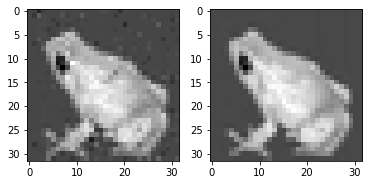

True label: 6
predicted label: 2
Time:  354.08523058891296  seconds
Initial fitness: 
 [-0.527806772929918, -0.4747470861949078, -0.49605630663175815, -0.5170278720529147, -0.5139365924752681, -0.4756392852080593, -0.4461514903447561, -0.45369866417689264, -0.4732731967998519, -0.48832065568331373, -0.49747762097299075, -0.4628652914989374, -0.4556599372345288, -0.5445561109468825, -0.5080199570178991, -0.5236074301001258, -0.5128694318516374, -0.5060366559603321, -0.43492744509366554, -0.5310152481130851, -0.4529983832296032, -0.4975810372087517, -0.47136706477113677, -0.5451509536410751, -0.4482082426416091, -0.517711736801803, -0.5000904054392392, -0.4538252210243815, -0.4933256561912782, -0.5216206414205096, -0.4872940708704079, -0.4913787195003745, -0.45504869885996874, -0.48069052277421714, -0.546285893493261, -0.5067408732831679, -0.5324443525570866, -0.45376290735200214, -0.4918493325593005, -0.485450607408541, -0.45228150760676633, -0.4302959985120256, -0.4334366403909803, -0.

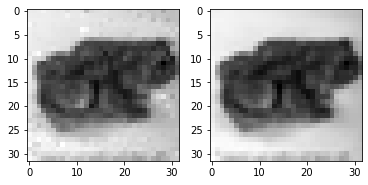

True label: 6
predicted label: 3
Time:  611.9010441303253  seconds
Initial fitness: 
 [-0.5994539271744583, -0.599712615055013, -0.5990229298862316, -0.5993321412220947, -0.5997261386166451, -0.5989836545636771, -0.5987342360699984, -0.6001816315683685, -0.6001483631665221, -0.5974691669931995, -0.5991466200348845, -0.5991366304404571, -0.5991353576546474, -0.5992952566485921, -0.5993574082663075, -0.5998145319381258, -0.5995098247362974, -0.5996824402199006, -0.5992467842012082, -0.5990143113090669, -0.5994013125850449, -0.598946407121922, -0.598641785593288, -0.59931304767519, -0.5992751077558106, -0.5987635917292888, -0.5990110119561567, -0.5989537366055534, -0.5986347889817945, -0.5994015755297515, -0.5990402000664056, -0.599044886692148, -0.5994143948537097, -0.5987901475772797, -0.5991070977860344, -0.5991005197693274, -0.5990048116449725, -0.5996657983600888, -0.5993499595447564, -0.5986792734981845, -0.599464194710705, -0.5996909206805977, -0.5992236794926274, -0.59909286705403

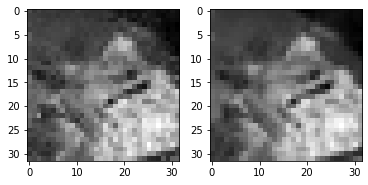

True label: 6
predicted label: 2
Time:  972.371527671814  seconds
Initial fitness: 
 [-0.24152103472301856, -0.13418798040388785, -0.1686104614110352, -0.1713916601728251, -0.0664590882281334, -0.13540612142085728, -0.2944443161140984, -0.055882658701138344, 0.03001657171202704, -0.15675277587748648, -0.0431910281937532, -0.15950950433417518, -0.3210071830659237, -0.16129910251777496, 0.023660142736055267, 0.12161137647689055, -0.05934684625103484, -0.05217418069428051, -0.13924484053319683, -0.20349526243006186, -0.24274206076569688, -0.08117485413352912, -0.17089912936998958, -0.16197047031673142, -0.2215974431707578, -0.08470301940732425, -0.19740898131975929, -0.13425368780946248, -0.11944029927249661, -0.2830546408750701, -0.054642247651877696, -0.13564882921877602, -0.11669369991989983, 0.12703639472838268, -0.1068230088442185, -0.08653372118736963, -0.07017530318190365, 0.06605093311861648, -0.10623874576581954, -0.005212616111733792, -0.1235395059444552, -0.15864347075134136, -

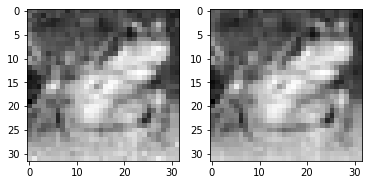

True label: 6
predicted label: 4
Time:  538.214170217514  seconds
Initial fitness: 
 [-0.60009478411295, -0.5999012342162213, -0.599945794071526, -0.5997810723362671, -0.599813862421005, -0.5999980768951598, -0.6002225120472684, -0.600116955988668, -0.599938167060766, -0.5999484102130994, -0.6000325311400853, -0.5998243658595138, -0.5998565159205291, -0.5999086196273725, -0.5999158085611267, -0.5998167350497061, -0.5998935935261576, -0.5997558007019561, -0.5998123758852341, -0.6000368073856497, -0.6001093297251613, -0.5998646006211585, -0.5997934509768209, -0.5999305024085058, -0.599938791206128, -0.6001171407339038, -0.5997983029558488, -0.600023051194843, -0.6000887557390612, -0.6000067056148733, -0.5999480124746155, -0.599817236573565, -0.5999271014012131, -0.599762076606237, -0.5998250150185453, -0.600260197122232, -0.5999704365064786, -0.6001569441694816, -0.5999287251590204, -0.5998359579969007, -0.5998159462101096, -0.6000058492815303, -0.6000861576261459, -0.5999427499092409, -

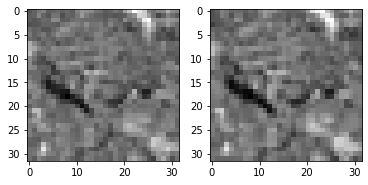

True label: 6
predicted label: 2
Time:  1027.3737540245056  seconds
Initial fitness: 
 [-0.5864621557102428, -0.5865835660384523, -0.5863291609559748, -0.5894723955703971, -0.5945038202044448, -0.5943916853411065, -0.5936858793784525, -0.5889931137581872, -0.5905240254631974, -0.5925865089715312, -0.5901399603596262, -0.5882009824736246, -0.5941342390508775, -0.5868699910754491, -0.5908687597925718, -0.5876126506669325, -0.5808966301495951, -0.588318006205655, -0.5789834039444238, -0.590312003504741, -0.5880979645614854, -0.5843349183546566, -0.5908359622011308, -0.5953263848879978, -0.5930000323148479, -0.5880236802292889, -0.5881092682730628, -0.5913471417772189, -0.586862121219587, -0.5908052148681384, -0.58737385558171, -0.5918718907159037, -0.5903836990497688, -0.587758433041976, -0.5863084194935788, -0.587578490118553, -0.5817195433216742, -0.5947638374143691, -0.587672919026366, -0.5874060557821663, -0.5909221839902461, -0.5900057894140578, -0.5903279114674118, -0.58886374895818

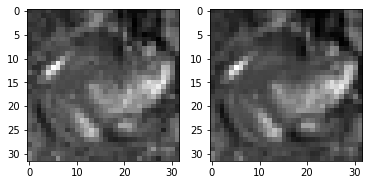

True label: 6
predicted label: 3
Time:  585.052717924118  seconds
Initial fitness: 
 [-0.5977881528200869, -0.5978652318376666, -0.5969557020392182, -0.596957367693315, -0.5976317589705138, -0.5981015756212985, -0.5975335757839791, -0.5978723138255624, -0.598607994314214, -0.5978893081468556, -0.5983094646576629, -0.5977260369026681, -0.5982126394463863, -0.5978578482289013, -0.5970788573705204, -0.5975884895686348, -0.5983265024778074, -0.59747168678801, -0.5975376609742867, -0.5973555970936578, -0.5977150461272889, -0.5983045847846836, -0.5986904225716186, -0.5981502883398894, -0.5976142841929872, -0.5973396299579858, -0.5985650774375246, -0.5973344714796062, -0.5973955367170969, -0.596841742216696, -0.5978096590776717, -0.5983349478230361, -0.5978209075288732, -0.5967869400490956, -0.5966413331488958, -0.5977879032890872, -0.5973850748844972, -0.5986228589958495, -0.5978355265623772, -0.598439567587533, -0.5978289590501691, -0.598455253386332, -0.5976423221646798, -0.597687717134835

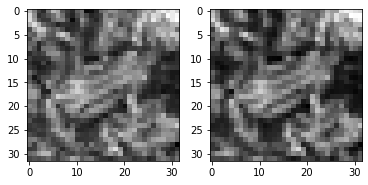

True label: 6
predicted label: 2
Time:  747.9802474975586  seconds
Initial fitness: 
 [-0.5961084256362529, -0.597036855878641, -0.5964453941789127, -0.5968262867404736, -0.596709329536929, -0.594997626672944, -0.596724920382569, -0.5950502883117443, -0.5976596194352103, -0.5968430312365121, -0.5978701625392232, -0.5976048953467789, -0.5967677061321344, -0.5987751206706258, -0.5970774705816597, -0.5962681068760096, -0.5972939252151264, -0.595193239365519, -0.5959192663207652, -0.5975283850986818, -0.5958365045014572, -0.597438282702049, -0.5968634993329985, -0.5978893835759711, -0.5956103036815419, -0.5986035234209763, -0.5997137012989701, -0.5968848704491627, -0.5973754447242495, -0.5976656168020603, -0.5956232307146034, -0.5980546895929422, -0.59399953304803, -0.5935641622183316, -0.5962469429469612, -0.5985480452552873, -0.5983927171561766, -0.5958534136641782, -0.5954916621891732, -0.5925147848347683, -0.596961432135878, -0.5964362185801272, -0.5976149112321618, -0.5966072068300965

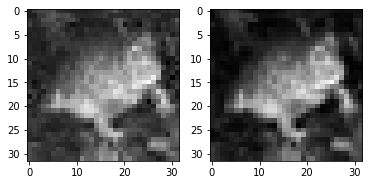

True label: 6
predicted label: 2
Time:  706.0119843482971  seconds
Initial fitness: 
 [-0.5991789917162972, -0.5977952085578089, -0.5991964712242774, -0.598055043009673, -0.5983638161978808, -0.5973124559304122, -0.597845160702734, -0.5983745985842047, -0.5987614824955236, -0.5971596617746604, -0.5974843935321482, -0.5981448139723087, -0.5985399328669546, -0.5981780313371071, -0.5982641402233683, -0.5983176221174116, -0.598310194688658, -0.5979876962064349, -0.5980217105145854, -0.5978064005691547, -0.5987186612618207, -0.5988035090273265, -0.5988003504279886, -0.5977579821032282, -0.5983892975060279, -0.5965477477745719, -0.5985320857174966, -0.5984502449214637, -0.5975920200552903, -0.5985041551867316, -0.598306816620652, -0.5985274760286862, -0.5988726550879134, -0.5982175059869451, -0.5978505902307443, -0.5988960613600386, -0.5980997679925182, -0.59910878296519, -0.5976145588645986, -0.5980811758078752, -0.5985802016416061, -0.5987850280604409, -0.5985164538498503, -0.5986233607544

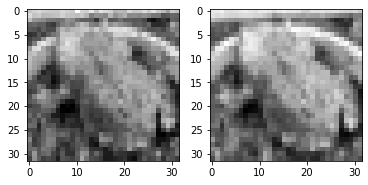

True label: 6
predicted label: 2
Time:  782.2289748191833  seconds
Initial fitness: 
 [-0.6015800459084757, -0.5994553130131544, -0.6003766901311386, -0.6013221242890456, -0.6002011237886608, -0.6004979546393853, -0.6007639104204296, -0.6010064288365147, -0.6016917170444158, -0.6011600149239511, -0.6008113884312214, -0.6020774325231106, -0.5991536138040205, -0.6011420115587325, -0.5999423380516343, -0.6014397989489514, -0.6023322146165567, -0.5992220869573686, -0.600749007765483, -0.6015447913033642, -0.5993096002490337, -0.6011668013580918, -0.6011873636106015, -0.6002974162461732, -0.599301784547301, -0.6008765683927212, -0.5995926283198396, -0.6010424464921206, -0.6011837999760049, -0.5991027913545173, -0.5995156482874913, -0.599388941457064, -0.5999720020512267, -0.6010045702475625, -0.6001003443493952, -0.6022147145568488, -0.6016370335410974, -0.5999831324767965, -0.5997527086813907, -0.6001011813256184, -0.5995293252604991, -0.600984184735978, -0.6017175068106777, -0.60125811480

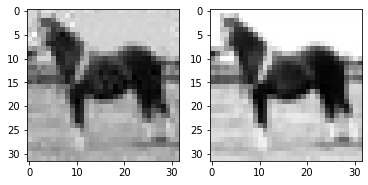

True label: 7
predicted label: 5
Time:  757.2027337551117  seconds
Initial fitness: 
 [-0.5985298663284171, -0.6005418087719605, -0.6004239549101503, -0.5987905690642653, -0.6038058773350718, -0.5990423403397859, -0.6003116973572846, -0.6059382345393287, -0.6057500715579913, -0.6023332127605627, -0.6031706801021716, -0.6016686232388221, -0.6045486598676295, -0.6008512902988492, -0.6036913054137685, -0.6054738209075582, -0.6077848563463263, -0.6015340832009477, -0.6050138866823689, -0.6021573810313801, -0.6002577164617466, -0.6025758894564444, -0.6005021652509517, -0.6005734173727755, -0.6036634323013552, -0.6022151558779008, -0.6039987335640687, -0.6051126011357401, -0.6005935669962983, -0.6000216343890049, -0.5993111510996696, -0.6040679074363386, -0.6060427265519767, -0.6048202975708818, -0.5963760279195093, -0.6051608259076084, -0.6035962282443679, -0.599388921124896, -0.5997645464400699, -0.6010145078655129, -0.5982109653006277, -0.6026331718909367, -0.6006572149970987, -0.60664445

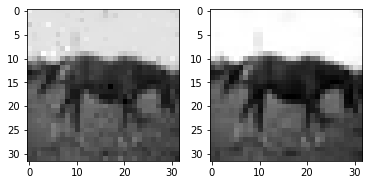

True label: 7
predicted label: 4
Time:  219.8901002407074  seconds
Initial fitness: 
 [-0.5997519674118204, -0.600573944705562, -0.6019663282607041, -0.6003823006970728, -0.5997344168408152, -0.599860162913325, -0.5998759950859365, -0.6003808224646312, -0.5995950248569654, -0.5999142448598185, -0.600022481748982, -0.5997194347003011, -0.5999781573529457, -0.6009646899633709, -0.6001160742556644, -0.5996640085891386, -0.600156750816622, -0.6000784865715528, -0.5997048508942976, -0.6003822489705899, -0.5999196549731419, -0.6000038994972, -0.5999673470199876, -0.6007577878284902, -0.5996437780715271, -0.5995208233844797, -0.5998608954963222, -0.5997051338924306, -0.6002939294701799, -0.5997475134486561, -0.5996378314264035, -0.5999530613568222, -0.600257243340043, -0.6010788117688031, -0.5997899320561313, -0.5999682911405599, -0.6009481262651001, -0.600031202614621, -0.5998180833934024, -0.6002917724747434, -0.6001894281043101, -0.5996471825202644, -0.6006883808726386, -0.6013276473398024

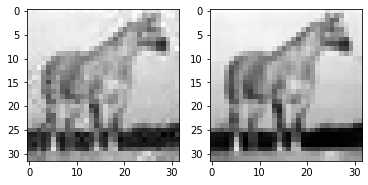

True label: 7
predicted label: 6
Time:  682.7584946155548  seconds
Initial fitness: 
 [-0.5579840418379166, -0.5325377056361933, -0.5463002387378523, -0.5656707804244396, -0.4258121855399578, -0.5665363946872103, -0.4831521556501547, -0.4708277288360765, -0.5048472666061385, -0.5408394530451087, -0.5392786426924796, -0.49760568493301444, -0.5140035045782531, -0.5094327683223829, -0.44766258371437717, -0.4976888753129993, -0.5600335500321012, -0.5006892142367978, -0.5329931192362956, -0.517973641710026, -0.539793319468598, -0.5259025890938642, -0.560844476080159, -0.5005386381031414, -0.5086186574487982, -0.5340896344437676, -0.4931149913250603, -0.5389624165665099, -0.5416644422571323, -0.5491768446903399, -0.5725492575969104, -0.5592113948329425, -0.566845350000565, -0.5209523575689424, -0.546016228225943, -0.5373265235602037, -0.47450210251496827, -0.5419081263007858, -0.47113796744702946, -0.512616771341491, -0.548378096811778, -0.5035853113137351, -0.5209471284622399, -0.5037359880

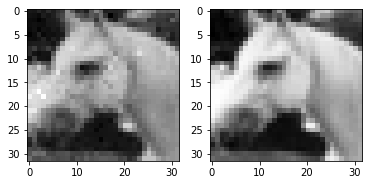

True label: 7
predicted label: 3
Time:  379.15737652778625  seconds
Initial fitness: 
 [-0.49177120594029844, -0.3982177826470319, -0.4820543406082456, -0.4494557820058328, -0.503457672773372, -0.4750762722023203, -0.5242991117039989, -0.5121747400141574, -0.5039268486414654, -0.4664923452970492, -0.49796316616547287, -0.4501334627864164, -0.5120741183488846, -0.519037114807621, -0.45795556715057195, -0.4490849994874536, -0.36602906013362696, -0.46316233638492765, -0.48484145768958303, -0.4823390147862875, -0.5147049059572139, -0.39548219827696707, -0.4389834597437823, -0.49255769748870293, -0.44635707550333625, -0.5129620887035452, -0.49478145761081366, -0.4953594194334342, -0.4592437508922329, -0.44743831824516167, -0.5508174029152859, -0.4480090016977569, -0.5000084108903192, -0.49809315264263954, -0.5072642572802213, -0.48080185950329135, -0.4744131135501969, -0.4654322056173512, -0.4605868139340744, -0.491485729510498, -0.4751520756465647, -0.43959254592106034, -0.4954411025039447

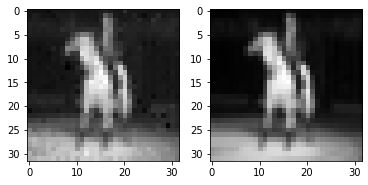

True label: 7
predicted label: 5
Time:  470.83247542381287  seconds
Initial fitness: 
 [-0.6007931547883133, -0.6006892837468325, -0.6001753300223669, -0.6000889804827354, -0.6002056357763247, -0.6000808197635117, -0.601151834400237, -0.6001267659777957, -0.6003514782562249, -0.6002724432315644, -0.6002917030126018, -0.6004561323131342, -0.6004905268527462, -0.6006197848956425, -0.6006487608622547, -0.6009216605373876, -0.5999866796180886, -0.6003147532381296, -0.6003237465930548, -0.6008226780379452, -0.6008112376229156, -0.6003573162150737, -0.6003980914957232, -0.6002388192990842, -0.6009665962776356, -0.6007228427212814, -0.600131641831404, -0.6005436721211185, -0.6001966259861539, -0.601026675264507, -0.6006498505912672, -0.6002637504051563, -0.6006507793154384, -0.601664548722538, -0.6004906095288476, -0.6006630870991561, -0.6007997377095964, -0.6002471608460873, -0.6025504949861046, -0.6003033896477463, -0.6013734700620453, -0.6001649869706013, -0.6005803582362104, -0.6017532719

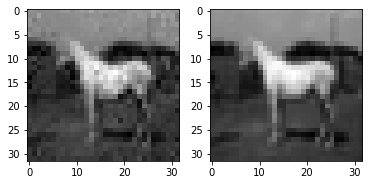

True label: 7
predicted label: 5
Time:  1031.8999905586243  seconds
Initial fitness: 
 [0.5733014432169246, 0.5725471247957283, 0.6432185437737932, 0.551817470844159, 0.5314761287534226, 0.5775769905528354, 0.6163758447108701, 0.6211977619369974, 0.6017850180905475, 0.5650593547118985, 0.5743706210516374, 0.5299182340537016, 0.5969833724505069, 0.6082304918962994, 0.6074003845960018, 0.628159727132929, 0.5978170758271042, 0.6684824753715469, 0.5738747848568109, 0.5700773187357472, 0.6174784230118869, 0.5596103672423346, 0.6376066633670967, 0.5900548238834776, 0.5263820068296825, 0.6352942845201167, 0.5972212049679207, 0.6153976248596496, 0.5413708192168606, 0.5679083978698043, 0.5755178361546534, 0.5608586162761902, 0.6056815779019472, 0.5113591866007952, 0.5660296433113718, 0.5850452049052904, 0.6007080285551601, 0.7364350254919833, 0.5521671453934727, 0.5411659957593358, 0.6492187529605544, 0.5717976395411954, 0.7079538037762123, 0.6041642081900812, 0.608995593690805, 0.5823439789806

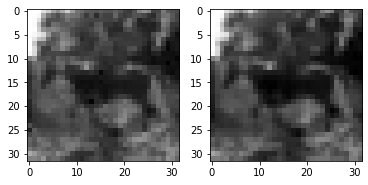

True label: 7
predicted label: 2
Time:  256.4101445674896  seconds
Initial fitness: 
 [0.2938403043973194, 0.08837355081785328, 0.3401561982777618, 0.20981777648451366, 0.2945242609447255, 0.35815265679856123, 0.3351702812163031, 0.306412569000743, 0.33875814703806023, 0.25663120453026533, 0.2733702240600384, 0.34097197546151836, 0.3404443515193234, 0.2854672713172913, 0.3013766051857815, 0.17671430520033965, 0.34462165151687535, 0.35013605983997786, 0.3709778739440499, 0.22602865689059956, 0.305541151364568, 0.38767743007549305, 0.2549481584774232, 0.21162476065991886, 0.3148878261846127, 0.5141051436450231, 0.3544776143454809, 0.3478427336150729, 0.34610984541224143, 0.19519848620436506, 0.2576426906381597, 0.2443901497147838, 0.37846974543395295, 0.32239136994946627, 0.337931740377041, 0.34188103609496295, 0.406933211847068, 0.45335165251019016, 0.40346719065193326, 0.28789010501727585, 0.29465875401729386, 0.25258774252565286, 0.4039511917402351, 0.5213237363677821, 0.3053559476350

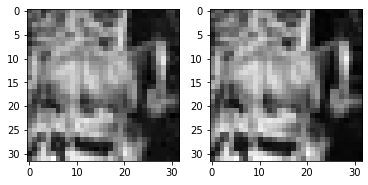

True label: 7
predicted label: 9
Time:  695.3492374420166  seconds
Initial fitness: 
 [0.13724168399791342, 0.33121306415107266, 0.19472972767465127, 0.16962706095762475, 0.30166981626076583, 0.14191796696663653, 0.019327750195341664, 0.2084002649706341, 0.35800006478680046, 0.2820695105622901, 0.1057162446041937, 0.597121683013575, 0.18810817495440932, 0.26057405224971175, 0.33587972842874614, 0.38843208204295065, 0.1611314910507924, 0.35241289174988794, 0.20061707638668988, 0.2577069458618212, 0.40230632743173106, 0.26032910981814295, 0.2982503347065963, 0.4642886717639666, 0.141959512503975, 0.24382232161748968, 0.2357807521903263, 0.24857059020595113, 0.1472845720671231, 0.2661065622237733, 0.2937034265938973, 0.32119170219048204, 0.17137532552877116, 0.1594884884008661, 0.23184330701875133, 0.3867923177498533, 0.32887668465804254, 0.1836945033675299, 0.07812881798328775, 0.1854171870614987, 0.4630916487745912, 0.2577885052273989, 0.14663459018378414, 0.2726258994899975, 0.33897160

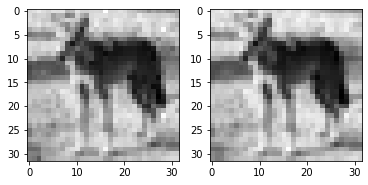

True label: 7
predicted label: 4
Time:  341.6225016117096  seconds
Initial fitness: 
 [-0.5826795609544827, -0.5823099208158734, -0.5824553957437143, -0.5853081912374647, -0.5771918784688773, -0.5773023880573153, -0.5745601568847789, -0.5734231320645603, -0.5702124745059198, -0.5723831600339407, -0.581777319776494, -0.5648253952223065, -0.5802198510490576, -0.5786472122748277, -0.5765970753089757, -0.5793597982759332, -0.5779572404036722, -0.5724455821846506, -0.5638547580618789, -0.5847589163878628, -0.577867143334254, -0.5655883966006343, -0.5824356378064484, -0.5763341457383717, -0.5742750871669356, -0.5846242445913171, -0.5811225453329627, -0.5759760436171909, -0.5631805522614799, -0.5764907366572555, -0.5690951991187754, -0.57770541533509, -0.5832944059129442, -0.5849961010351958, -0.5746028480512637, -0.5785801035279273, -0.5795066530246538, -0.5809403623511356, -0.5810120547503932, -0.5837349729462789, -0.5779401772633772, -0.5725268362580814, -0.5816679785296259, -0.57836524084

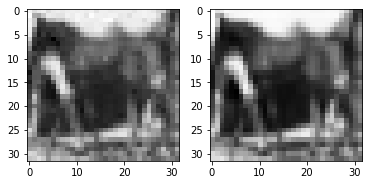

True label: 7
predicted label: 6
Time:  685.1137149333954  seconds
Initial fitness: 
 [-0.5975860272903012, -0.5952173471304225, -0.5964810324559087, -0.5977177304757583, -0.5971718411207216, -0.5973989037423726, -0.5969585301650244, -0.5966351402815177, -0.5968553454376166, -0.5971679683401818, -0.5958526450138542, -0.5944206720767256, -0.5971517494165969, -0.5975769453108895, -0.5969375300667493, -0.5940931489193717, -0.5979653367745134, -0.598575356495115, -0.5970222494977407, -0.597240449128615, -0.596021887427616, -0.594735987958704, -0.596078417039969, -0.5967988367016903, -0.5957131701874593, -0.596654302166267, -0.5966829333079922, -0.5972035289060359, -0.5968549323079982, -0.596566412371444, -0.597253267980538, -0.5954276182110574, -0.5964052293941443, -0.5972760701088913, -0.5974481291641267, -0.5978173775375232, -0.5970170393602875, -0.5978980243306382, -0.5971253709682969, -0.597075814228629, -0.5966566784533593, -0.5941445716773865, -0.5937435980355623, -0.5963984493880311

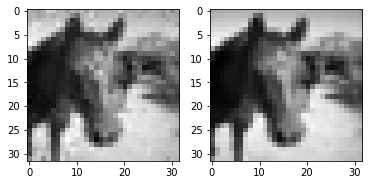

True label: 7
predicted label: 3
Time:  480.4509127140045  seconds
Initial fitness: 
 [-0.5883268453478436, -0.5928308621438523, -0.5891122507154496, -0.580221430196831, -0.5869682875762898, -0.5921881107337381, -0.5891387046848793, -0.5850429363990257, -0.5877719135647075, -0.5906154853961386, -0.5897554411773099, -0.5852452319893258, -0.5894317590110626, -0.5928265818760609, -0.5907746594247619, -0.5901608683163, -0.5843118969481849, -0.589501943261911, -0.5928558856816776, -0.5903661535196915, -0.5863529083040492, -0.5932547211086295, -0.5897099676126974, -0.5943317343519431, -0.589902967873045, -0.5885643269831599, -0.5886093569969363, -0.5884479265093688, -0.5891151074379176, -0.5826238964623063, -0.590350264083942, -0.5899307397169664, -0.5890957396033257, -0.5870958765209209, -0.5879550804406684, -0.5388790702958045, -0.5914802235088512, -0.5885940035312358, -0.5879685346930802, -0.5840172408593904, -0.59102431505556, -0.583562873503716, -0.590761002031858, -0.5836701479387101, 

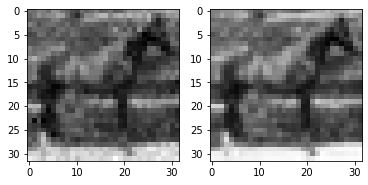

True label: 7
predicted label: 4
Time:  556.299364566803  seconds
Initial fitness: 
 [-0.3374843213676696, -0.2939459266913993, -0.17897825649657936, -0.31069312011201783, -0.3015231040647318, -0.26371377531101736, -0.2872642351006174, -0.23713763286247078, -0.0705737709030208, -0.18771362029606806, -0.3114652697454957, -0.1738271983368567, -0.25395820486377974, -0.29117197318428556, -0.16193817069986374, -0.1721118389479001, -0.20410775953710758, -0.4363380269832581, -0.3415585830973077, -0.3509740680988106, -0.30567909308129093, -0.1791921172239579, -0.3733338736637728, -0.16010824066045828, -0.3086752010450744, -0.4127255139314543, -0.41266925819791356, -0.30206195057872076, -0.2968069153896756, -0.32262412347834424, -0.2809536587386547, -0.16446161352323813, -0.0970070649263457, -0.2683067682543012, -0.2341180821290645, -0.3349030259366626, -0.29415633737668473, -0.32863881946099316, -0.26170923395946544, -0.27851769316127295, -0.14363055722403661, -0.3497786618747524, -0.305112203

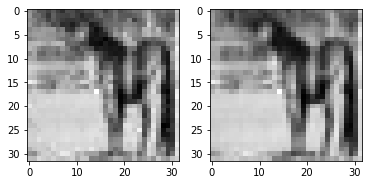

True label: 7
predicted label: 4
Time:  258.7367663383484  seconds
Initial fitness: 
 [-0.5995712869221549, -0.5997381516143677, -0.5997544016905515, -0.5989581792732499, -0.5997437118240802, -0.5997305349434622, -0.6004352926866992, -0.5995445869392331, -0.5991627797941815, -0.5993426066697558, -0.5996307390685803, -0.5994662385456739, -0.5995428672595411, -0.6000257710285073, -0.59955128999335, -0.5993741729543363, -0.5997812795762405, -0.5995089577705311, -0.5997075021029017, -0.6006414846136537, -0.6002815327395474, -0.5994262361949609, -0.5993489166136513, -0.5998427002196502, -0.5997454124060759, -0.5994626238006364, -0.5992689200352981, -0.5995839473026944, -0.6012451103975268, -0.5989323007466107, -0.6002259612223961, -0.5994117285717186, -0.5993971339240887, -0.598584107221862, -0.5994243180721134, -0.6001881966415323, -0.6004102538289999, -0.599212260303249, -0.5992599520922899, -0.5992239424416406, -0.5995041514988754, -0.6000171946278134, -0.5998015888223163, -0.59938296457

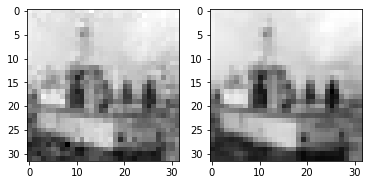

True label: 8
predicted label: 9
Time:  704.5660662651062  seconds
Initial fitness: 
 [-0.5583407276085937, -0.5800010841469485, -0.573024377823972, -0.5768208934833415, -0.5668502675363316, -0.5616016038757314, -0.5681156260997933, -0.5763998310483877, -0.5643602325468995, -0.5580477684281124, -0.5729900229630693, -0.5558786171964931, -0.573974426530202, -0.5715549302412162, -0.5702019742939796, -0.5734218516927104, -0.564443648055893, -0.56306998681007, -0.5768351347687486, -0.570935584478027, -0.5703694076227684, -0.5570499092833228, -0.5561408818976012, -0.5705875899260007, -0.5763941987257556, -0.5791066799433464, -0.5616331525357773, -0.5735919223654322, -0.5544313518543528, -0.5753701984829676, -0.5782025463027024, -0.57660182337267, -0.5705443291576706, -0.578138752733862, -0.5830799906908138, -0.5455708080528635, -0.575246543268078, -0.5646622670166412, -0.5665712966167176, -0.5734193399540913, -0.5556086869507074, -0.5741694448346361, -0.5860145693096321, -0.571441811048279, 

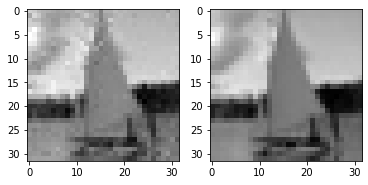

True label: 8
predicted label: 4
Time:  480.01328921318054  seconds
Initial fitness: 
 [-0.31191155575368446, -0.35987403429409603, -0.36466305379509545, -0.24397972564360218, -0.330561473881149, -0.39393558672653217, -0.3318816304724793, -0.3832773764620478, -0.3825889740840666, -0.4754392391013563, -0.2367953533085619, -0.4027341411636507, -0.3823390699920318, -0.33452715861758175, -0.37431733095890396, -0.3550666004235481, -0.25439087329453175, -0.2868549073646163, -0.21366553229085694, -0.3520805968379507, -0.38174258535811956, -0.3867966096966774, -0.15416881447337027, -0.2375453975632545, -0.015809910828518375, -0.25424024862935624, -0.2532899894556935, -0.3372865976259851, -0.3992263428868062, -0.31339745572407907, -0.4746221710733198, -0.41363914075832764, -0.3391704484192083, -0.3940619041418083, -0.15386221775285364, -0.3510956592389055, -0.31249851311044935, -0.36005577305078995, -0.3790043446556734, -0.3535741430327234, -0.3380422944364785, -0.3648974017866791, -0.317402179

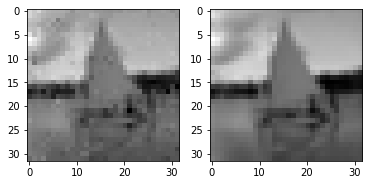

True label: 8
predicted label: 0
Time:  369.507080078125  seconds
Initial fitness: 
 [-0.5999777592651614, -0.6011323800661119, -0.6045406061188131, -0.6023066674375361, -0.6006605826966996, -0.6022797822626861, -0.6004540641709203, -0.6047202426403226, -0.603048120630789, -0.6020101495584528, -0.6001239664439465, -0.6036696562187912, -0.6013484642094346, -0.5999834485009883, -0.6115151094606539, -0.6010318304773864, -0.602855596801797, -0.6053820475493792, -0.6058085342411377, -0.6013374160562753, -0.6061087846989893, -0.6017675765311742, -0.600823323325193, -0.6015746184571935, -0.6060582862206051, -0.6020917358885218, -0.605871629313885, -0.6083715807414374, -0.6081216513321859, -0.6055839122313769, -0.6014100484915431, -0.603372412094173, -0.5999693579147491, -0.6057393913936241, -0.6068334549974566, -0.6002556108327974, -0.6051447741690148, -0.6003252810516075, -0.601281828523688, -0.6029776645179781, -0.6027634062046852, -0.6074532852664756, -0.606199217510339, -0.606080494648084

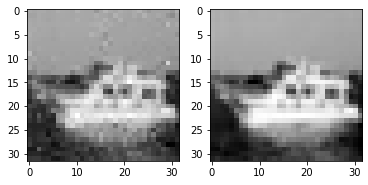

True label: 8
predicted label: 0
Time:  427.12602972984314  seconds
Initial fitness: 
 [-0.5994612426812056, -0.599449192128985, -0.5996128171241759, -0.5996643012539935, -0.5994411019161745, -0.5996603342456627, -0.5996297522357273, -0.5996958254710039, -0.5994858678538487, -0.599558699359589, -0.599738327974414, -0.5996074064986854, -0.5995837859005736, -0.5994564298539021, -0.5996795665448432, -0.5996773969663274, -0.5994319711271318, -0.5992056672237746, -0.5996736833323808, -0.5994761436117608, -0.5996345286151609, -0.5997858403159666, -0.5996480204366645, -0.5995453457212605, -0.5995607367463027, -0.5995079265084813, -0.5996456571490766, -0.5992968795801779, -0.5995301973026861, -0.5989475388903656, -0.5995597720071769, -0.5996919964397166, -0.5998301546099831, -0.5995118052694122, -0.5996000562521039, -0.5993412648162431, -0.5998504782584232, -0.5994188420082933, -0.5993578248617368, -0.5996937388476837, -0.5993783164641133, -0.599207526191794, -0.5995552013638, -0.5993600000721

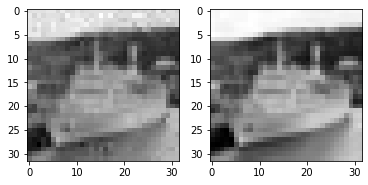

True label: 8
predicted label: 9
Time:  552.4639256000519  seconds
Initial fitness: 
 [-0.598734782587038, -0.5949291631038099, -0.592234851032895, -0.5910720734579625, -0.5932137187196849, -0.5933096211052755, -0.5987761882267194, -0.5886820774858229, -0.5921994200986063, -0.5851620574001775, -0.5951166549259451, -0.5827604445915365, -0.5932626101603942, -0.5943313806015171, -0.5797062074028477, -0.593965298730937, -0.5903459075126309, -0.5885496180891103, -0.5844612135981562, -0.5879562803822351, -0.5869382565144126, -0.590287270739149, -0.5943441304856478, -0.5890146364285722, -0.5942482547039145, -0.589850990985715, -0.5941212801568678, -0.5656574938820672, -0.592615070669163, -0.590458967554413, -0.5887173827282928, -0.5936451808854206, -0.5974520853854935, -0.5927885307223357, -0.5876219844519746, -0.5847288942764874, -0.593543940687435, -0.590360523701996, -0.5843131449932749, -0.5944360962183356, -0.5841845006460373, -0.594802094358552, -0.5869453811021199, -0.5907757145974242,

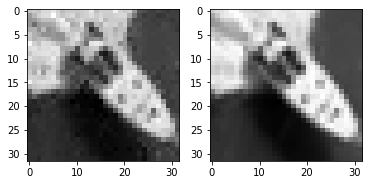

True label: 8
predicted label: 0
Time:  509.137761592865  seconds
Initial fitness: 
 [-0.6013589286445772, -0.6001988253601961, -0.6016128585982332, -0.603549637977032, -0.6016673692485972, -0.6010350162937409, -0.6005922204173357, -0.6016815854090097, -0.6020041859305157, -0.6041876131441903, -0.6014367371817544, -0.6020463085167049, -0.6007044857001411, -0.6028655442716289, -0.6007413882565935, -0.6028149665403015, -0.6012480870103248, -0.6035987940343305, -0.6004109465675169, -0.6018033808524837, -0.6027730616753206, -0.6062025206605028, -0.602213031149714, -0.6003590700830888, -0.6033606406962296, -0.6015158826952399, -0.6005137975611231, -0.6002105520382289, -0.6000821065905573, -0.6009047272114058, -0.6004087723858428, -0.6012199797662241, -0.6021318766748288, -0.6031161499770767, -0.6002529855483325, -0.6051888854156287, -0.6029377078247258, -0.6018412603681211, -0.6002088815517544, -0.6037607253188679, -0.6054886398694406, -0.6013235595885371, -0.6005202901815043, -0.6000496437

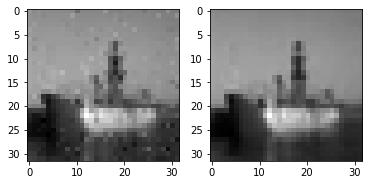

True label: 8
predicted label: 4
Time:  289.9069001674652  seconds
Initial fitness: 
 [-0.5997594068113362, -0.6000751576211864, -0.5996080051828977, -0.5998792333785389, -0.5998148849690162, -0.5996459226067207, -0.5996541008104443, -0.5999897022985621, -0.6000023516131399, -0.5996472377353668, -0.5999793456201514, -0.5997032676967724, -0.5998274316998505, -0.5997920109257634, -0.5999035605561471, -0.5999472979587167, -0.5996435574634194, -0.5996026793895085, -0.5997583356321725, -0.599742992721647, -0.5998902545399667, -0.5999734771716765, -0.5997562023119261, -0.5998414386627111, -0.5995408828768947, -0.5999220550525304, -0.6001227535159227, -0.5994875048883808, -0.599687511400407, -0.5997942518046219, -0.5997456548101789, -0.599811278231301, -0.5999295853079141, -0.5997750390971425, -0.5999966108610448, -0.599713426280989, -0.5999479605043686, -0.5998304155536784, -0.599760132871997, -0.5997457206401173, -0.5999296207950326, -0.59964467088728, -0.5996373321721774, -0.59972465708248

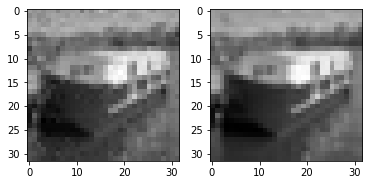

True label: 8
predicted label: 6
Time:  498.33792185783386  seconds
Initial fitness: 
 [-0.4842794989945759, -0.38125807744144213, -0.3183604318076673, 0.1109528764103815, -0.2307532099064015, -0.3504744354384587, -0.23563755090092608, -0.276923147662122, -0.284553744795113, -0.3665594031224184, -0.3915471118024684, -0.35367035105237626, -0.42946319110689246, -0.45250579767973786, -0.17447798377721024, -0.3373149383980759, -0.48996596849634155, -0.38098336408280764, -0.2840922464872975, -0.2000479958877578, -0.2967542698278141, -0.3748715861949496, -0.38271978229673226, -0.2986950262806915, -0.33566533290837997, -0.45118287224904036, -0.3381564820613623, -0.34872864900622336, -0.18813738486385856, -0.20344602516399335, -0.23043612193687638, -0.3666260547701016, -0.22758264665895492, -0.13525214424852525, -0.37265510118009604, -0.3755858403671062, -0.300970521498685, -0.4902675095861463, -0.3742934555491488, -0.5183958299605387, -0.23539006676068258, -0.42324967911279343, -0.28739072563

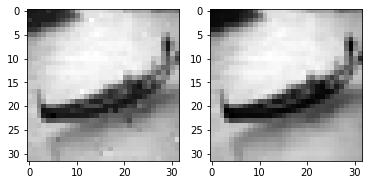

True label: 8
predicted label: 0
Time:  187.1376667022705  seconds
Initial fitness: 
 [-0.599779031647272, -0.6032350541915326, -0.6018151374683403, -0.6007573856375398, -0.6044248410363448, -0.5993653206265984, -0.6017157628227374, -0.5999146972547087, -0.599719860100704, -0.6001847104787809, -0.60320952231687, -0.5998931885097329, -0.6039743286730526, -0.6034088912047941, -0.6056773174955501, -0.6009119899317561, -0.6036000448446095, -0.5995411101879102, -0.6036234458645372, -0.6016177423660486, -0.599967785330798, -0.5996091395413305, -0.5995762402472138, -0.6008645286244658, -0.6002083666575719, -0.6064712053481763, -0.5994252338659936, -0.5999281489920723, -0.600215874225293, -0.6006890177810417, -0.6027790852570718, -0.601018620140262, -0.6026255137336789, -0.5991471718306483, -0.5929862401126388, -0.6027486121649597, -0.6025051084900834, -0.6001383143832577, -0.599386414247788, -0.6031150404092367, -0.6009199054354177, -0.6051108859673618, -0.6017082668052843, -0.602616991427426

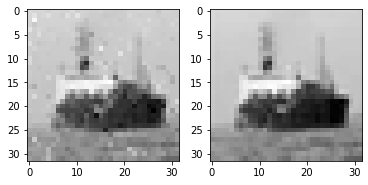

True label: 8
predicted label: 6
Time:  263.95125102996826  seconds
Initial fitness: 
 [-0.600959730084792, -0.600087685081151, -0.6005988432043589, -0.6003080550439271, -0.6002070123244772, -0.6002418172139315, -0.6001356191430063, -0.600679637031415, -0.6005397194301689, -0.6000796119343597, -0.6001108220936342, -0.6001013557818, -0.6004957476983086, -0.6001640374447497, -0.6004223855456475, -0.6004954156290901, -0.600028632923214, -0.6003014071535585, -0.6007267543258997, -0.6000782492983746, -0.6011134015323254, -0.6004169355941332, -0.6000349081882712, -0.6006959066284995, -0.6001375049375888, -0.6015974086025331, -0.6001575671709221, -0.6001540907788347, -0.6001840411223408, -0.600394759331796, -0.6003872759829653, -0.6006679019882313, -0.6000077969970267, -0.600529825146739, -0.6000965569312515, -0.6003000056800639, -0.6004135220740463, -0.6005055550804874, -0.6003637479035072, -0.6002247824783932, -0.6001607514295171, -0.6001638788540488, -0.6000740046899692, -0.600103738759501

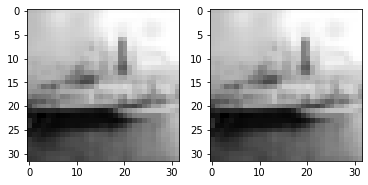

True label: 8
predicted label: 8
Time:  115.42240333557129  seconds
Initial fitness: 
 [-0.5991498844639126, -0.5995856896184668, -0.5997758092503873, -0.5996451524745565, -0.5997256008187912, -0.599744538235692, -0.5997613561300157, -0.5996226590017668, -0.5997815427827434, -0.599560489908959, -0.5996569365979516, -0.5995908295454238, -0.5997649433802895, -0.5992870645766523, -0.5994349200878432, -0.59960305387336, -0.5992775838424962, -0.5995025383889815, -0.599474327825586, -0.5996814851348784, -0.5996527065457423, -0.599301192536345, -0.5996801526949521, -0.599718987291797, -0.5995697795349653, -0.5996307471395081, -0.599562036279432, -0.5999317181249869, -0.5995177522943158, -0.5993433947332418, -0.5991822628643358, -0.5993482920158606, -0.5994690856957061, -0.5994323139247109, -0.5997035794420674, -0.5999339150953815, -0.5991271420880822, -0.5996588616838678, -0.5996091800304657, -0.5996588030506327, -0.5993812569268284, -0.5995118457566394, -0.5995030603327801, -0.59971502558812

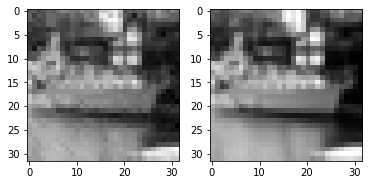

True label: 8
predicted label: 3
Time:  842.5134437084198  seconds
Initial fitness: 
 [-0.6011958863007428, -0.6020691003832405, -0.603676134406555, -0.6022649366650188, -0.6030280499151732, -0.6033120199356403, -0.602905885225326, -0.6006210500696672, -0.6037209806269777, -0.6013326524000489, -0.6014866250756891, -0.6029426669281197, -0.6019447904176971, -0.6012401792950717, -0.6004983399571283, -0.6038617715059438, -0.6072256492254346, -0.6017207117287615, -0.6015298615458501, -0.6021440134452144, -0.6040288210929718, -0.6004912049369068, -0.6025915712466758, -0.6011760567577572, -0.6012774093730536, -0.6016645155778269, -0.6027505385775587, -0.6032480621772865, -0.6011200140352165, -0.6021557612117615, -0.6020750940904143, -0.6019745051770904, -0.6076478555815137, -0.6062055634369097, -0.603087732543487, -0.6018970107687718, -0.6001594441378424, -0.6056489445647819, -0.6018816316203339, -0.6026284346281804, -0.6023181595857913, -0.6023071628217314, -0.6014639852443121, -0.6027445419

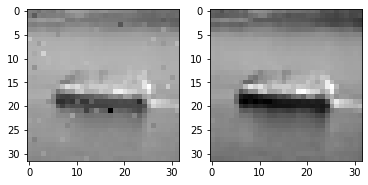

True label: 8
predicted label: 0
Time:  143.43750476837158  seconds
Initial fitness: 
 [-0.5999433641494787, -0.5999039041293548, -0.5999074530492794, -0.5999167847781623, -0.599981611980049, -0.5999833304854568, -0.5999192600742844, -0.6000745610850395, -0.5999186477558159, -0.600008393383548, -0.5999180157850892, -0.6000097070302449, -0.5999983675727855, -0.5999595101729656, -0.5999785099613135, -0.600082818745423, -0.6000080416211783, -0.5999910417047587, -0.5999463438623601, -0.5999001016553835, -0.5999489692331541, -0.6001266904571193, -0.5999822048842319, -0.6001118643609533, -0.599987373768178, -0.5999519686954405, -0.6000247075487238, -0.5999513062983524, -0.5999687275143663, -0.5999281177614899, -0.5999482942594975, -0.5999246609832815, -0.6001175226866803, -0.5999660348477736, -0.59989570190166, -0.5999200500168315, -0.5999959182079124, -0.6001816025306735, -0.5999816262862707, -0.6000026902901614, -0.599898666169206, -0.5999576765457598, -0.5999353140811591, -0.6000927034450

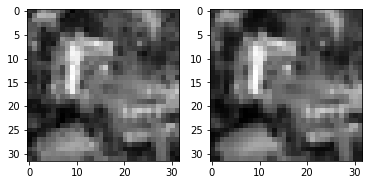

True label: 9
predicted label: 4
Time:  797.4628915786743  seconds
Initial fitness: 
 [-0.2939578822501754, -0.10256458792345788, -0.30221252974520063, -0.28540911316841167, -0.2801460630323272, -0.11924358092085852, -0.34788144791590936, -0.35130466491200535, -0.24861599133851728, -0.1258359650808931, -0.33618662636627317, -0.056172909682727284, -0.17031158198158933, -0.26424392680027653, -0.20886888917187652, -0.3540800629552161, -0.2350864630555913, -0.23914581906795132, -0.2929646208098453, -0.2936486649905337, -0.22931487286033594, -0.26447094902230134, -0.20768833205198978, -0.26611776722686936, -0.06886879393813763, -0.1834308673640106, -0.22846361471607035, -0.2714752989583391, -0.2283282364828495, -0.2560957838129888, -0.1724494379409455, -0.32683405384976916, -0.1648573629461758, -0.26167459348006034, -0.31349434452048985, -0.12079069282158567, -0.11401065077290662, -0.26883348764999665, -0.0948644480928161, -0.22682294031464958, -0.21055314856321963, -0.3464807903463265, -0.

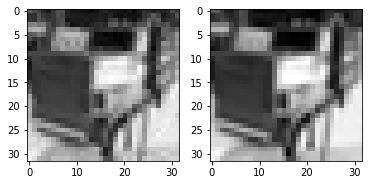

True label: 9
predicted label: 1
Time:  520.3207898139954  seconds
Initial fitness: 
 [-0.5980537870535322, -0.5976189965724427, -0.59852329339693, -0.5979444767865871, -0.5985799699626478, -0.5980373278512777, -0.5977095291808444, -0.5979627690942672, -0.5993716025002854, -0.5989637921734057, -0.5994589502297991, -0.5982781446953402, -0.5981989955897354, -0.5974689955149607, -0.5979684166195168, -0.5996826464758076, -0.596985972865782, -0.596176366417839, -0.5979796538766715, -0.5997414934328328, -0.5986544420683761, -0.5998286737326258, -0.5954104052105644, -0.597555671327984, -0.597994467114617, -0.5965599329924712, -0.5969295850688074, -0.5981252974612322, -0.5987106825881258, -0.5979306642319123, -0.5980318945626, -0.5979763724981888, -0.5999838928049257, -0.5958563431134637, -0.5979782066071351, -0.597813616697022, -0.5994272363176496, -0.5982367112223905, -0.5972565410934245, -0.5983175137951393, -0.5982662421300434, -0.5974766204816494, -0.5986204028786584, -0.6000389039660914,

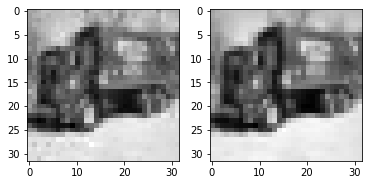

True label: 9
predicted label: 1
Time:  629.085244178772  seconds
Initial fitness: 
 [-0.6035121963131296, -0.6006097459864775, -0.6048129807733826, -0.6084376874084688, -0.6043155012725238, -0.6025969552068535, -0.6035297357998491, -0.6011867857668749, -0.6006641385525232, -0.6026690976913767, -0.6073687781366054, -0.60009721500503, -0.5999447552256217, -0.5999149833097849, -0.6001180700401791, -0.6041129940011635, -0.6052068607339303, -0.6004218470155059, -0.6062359530848421, -0.6042685288306112, -0.60169826857719, -0.5996881637130509, -0.6001678604248795, -0.600101039200358, -0.6006474429359496, -0.5999402222714391, -0.6014302093936315, -0.5999123892795816, -0.6000742089002825, -0.6056044079360361, -0.6008991207640104, -0.6003978667397947, -0.6020131048695655, -0.6002746935121992, -0.6068361839863933, -0.6013672046271643, -0.6029657375918256, -0.6024971733935971, -0.60306561404456, -0.6014924251565299, -0.6021781466061324, -0.602155012931967, -0.6063115806235458, -0.6023497077198892

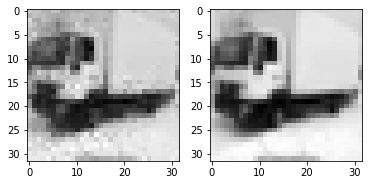

True label: 9
predicted label: 8
Time:  473.2307651042938  seconds
Initial fitness: 
 [-0.6000757662865526, -0.6010062064079349, -0.601043466420194, -0.5999570471714255, -0.599983146311532, -0.6032776040520499, -0.6032391648422347, -0.5999171451326941, -0.5996884453087328, -0.6007791548887386, -0.6009144526620964, -0.6002662600133037, -0.6027594246068924, -0.6007913067982288, -0.6002439364333398, -0.6007020809315994, -0.5996134358791364, -0.6020619006957912, -0.5999043078228663, -0.6005571710909948, -0.6012826387767759, -0.6015950746777375, -0.5997711073965497, -0.6035091642055715, -0.6002055749646896, -0.6014721428643215, -0.5998178888842335, -0.6001365557363453, -0.6004688802316887, -0.6016882764508326, -0.6040832121989558, -0.6003549580918712, -0.5998978211144451, -0.5999418881183852, -0.6004241014298322, -0.5998845323566095, -0.5997667446786321, -0.6013965551906264, -0.6002098853854508, -0.6035425881022718, -0.5998889957434717, -0.6028811828127747, -0.6012173331453137, -0.600809063

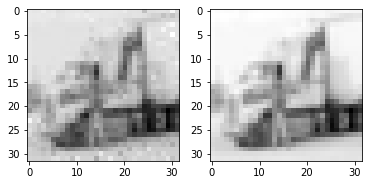

True label: 9
predicted label: 8
Time:  289.1973388195038  seconds
Initial fitness: 
 [-0.6000563638943117, -0.6002505858231998, -0.6000625168779798, -0.6000517138027264, -0.6000325243610499, -0.6000596742802846, -0.6000587974801517, -0.6002662939057759, -0.6000646496379838, -0.6000946307640995, -0.6000052147696876, -0.6000413927789447, -0.6002353406590765, -0.6000806877364256, -0.6000266513007504, -0.6000574024033016, -0.6000307294903731, -0.6006670388986403, -0.6000971140095611, -0.6001384645165972, -0.6003703827558261, -0.6001488817260174, -0.6001880751679688, -0.6000942370259084, -0.6000926501869719, -0.6000628802549179, -0.6002070054527058, -0.6000562440761179, -0.6000342986919214, -0.6001736830312491, -0.6000556425892396, -0.6001204980181749, -0.6000830193511962, -0.6001555881336356, -0.6001848129347587, -0.6001907107864101, -0.6000639840304745, -0.6003119719932467, -0.6001051955634364, -0.6001720610703861, -0.6001169435028, -0.6005755515074684, -0.6001025727419986, -0.6001774602

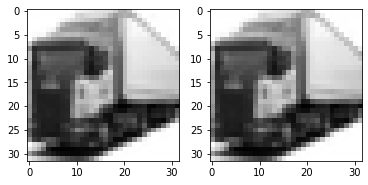

True label: 9
predicted label: 9
Time:  117.13877248764038  seconds
Initial fitness: 
 [-0.4695534289433827, -0.498626053479304, -0.47752818724698, -0.5224922790733267, -0.48144670691711516, -0.47258695780120186, -0.511873399508516, -0.5361135437874323, -0.5091075732144981, -0.49026134471783867, -0.4686371524534416, -0.44004733598635026, -0.4767486150129288, -0.4854818718838352, -0.46178123662543746, -0.4614331267947157, -0.5073868871254237, -0.43071513999093725, -0.5035227675877807, -0.4759340424502967, -0.4784899194297888, -0.47702139103216373, -0.41450163630375647, -0.5134869825353237, -0.4875210360398806, -0.4817354514223212, -0.4768187437428642, -0.5377828124212147, -0.48895020528035804, -0.46610967730725905, -0.5374106936896847, -0.47412744512013616, -0.4990014136678659, -0.5234072821555307, -0.484890560988878, -0.4852318685601957, -0.4714974728293285, -0.504292535485014, -0.4699584950796136, -0.4762049233282747, -0.5158479559287792, -0.5059129798662766, -0.5149185232721183, -0.4

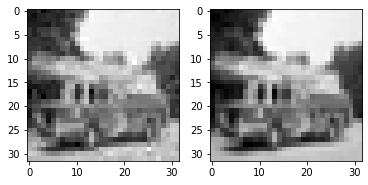

True label: 9
predicted label: 1
Time:  609.0052909851074  seconds
Initial fitness: 
 [-0.5997581129044833, -0.5998582220149182, -0.600048146282882, -0.5997551875582045, -0.5997705785109564, -0.5997616888798022, -0.5998284541158465, -0.5998659809087478, -0.5998622222496319, -0.5998506888715772, -0.5997826100145544, -0.5999225454155056, -0.6000145990411107, -0.5997764591612765, -0.5998280498622841, -0.5997790766339349, -0.5997540805813485, -0.5999672203938153, -0.5998003372605547, -0.5997772517325873, -0.599987347140606, -0.599952596891711, -0.5999170197919403, -0.5997626967405331, -0.6000309350248207, -0.5999353004582095, -0.5999350294180783, -0.599918013488368, -0.5999370000431767, -0.5999849992513295, -0.5999068136835014, -0.5998890633944918, -0.5999071341797383, -0.5999005497376758, -0.6000267934268441, -0.5998051000075912, -0.599939207807303, -0.5997642651462047, -0.5998288632894735, -0.599860475188759, -0.5999038397342797, -0.5998181973462563, -0.599628522441654, -0.59958835717095

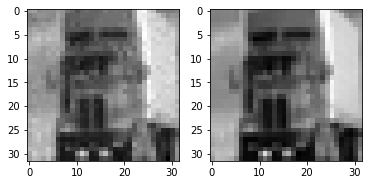

True label: 9
predicted label: 1
Time:  910.4563477039337  seconds
Initial fitness: 
 [-0.5281497063146112, -0.5126098545537657, -0.514566716804505, -0.5160600413513452, -0.5134858921403997, -0.523754262464809, -0.5184693401245546, -0.5128779994681816, -0.525725942760393, -0.5236153274869073, -0.5503414610556508, -0.5204306515022348, -0.5067434744226058, -0.5240601294951184, -0.5125303856753001, -0.5203137869863349, -0.5146868053268516, -0.5116038049396324, -0.536194352177734, -0.5142038076571686, -0.5260304925166553, -0.5047290156053615, -0.5169847563535319, -0.5382623137879017, -0.5040609236696466, -0.5286747086005658, -0.526942027312302, -0.5345856278664343, -0.5179957964489279, -0.5341548264346161, -0.5317583966646969, -0.5065074717417648, -0.5118455009610738, -0.5263927606965471, -0.5254321117829173, -0.5094811156194581, -0.5346074086535937, -0.4958327412109841, -0.5186160336879833, -0.5361264224926848, -0.5467260485040106, -0.5295542185927505, -0.5267384833680632, -0.524676523860

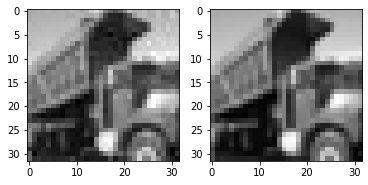

True label: 9
predicted label: 2
Time:  917.1127347946167  seconds
Initial fitness: 
 [-0.5975087302650026, -0.5982450883383995, -0.5980391902534895, -0.5987593766451959, -0.5984599059182686, -0.5980523627939589, -0.5986762754141954, -0.5990271399232568, -0.5991045113767987, -0.5969709746213047, -0.5981432542155984, -0.59818887884151, -0.5978534915802058, -0.5974182007902267, -0.5948684541744822, -0.5985828357974909, -0.5977790674260016, -0.5983512092901383, -0.5969196384309453, -0.5989523275693198, -0.5959498228422007, -0.5991929648822503, -0.5995909178923533, -0.5987006878595474, -0.5994027159048014, -0.5982275633097598, -0.5974056836873356, -0.5957208083628301, -0.5981118278114755, -0.5978566127747402, -0.5979302357986425, -0.5967944854336581, -0.5974764262800601, -0.598492129083193, -0.5975617734309081, -0.5973599909935294, -0.5959875802443432, -0.5969515047328706, -0.5984358699230654, -0.597354583869473, -0.5974609387828483, -0.5969566767625387, -0.5990351206262807, -0.59803746070

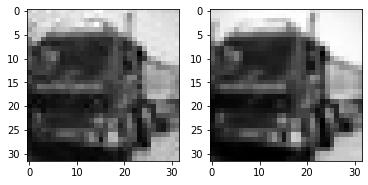

True label: 9
predicted label: 1
Time:  1229.2536551952362  seconds
Initial fitness: 
 [0.23836015116971657, -0.22497375371458472, 0.07924196323009079, -0.005355888252362356, 0.0787983069365179, 0.06655500539398729, 0.1125757517548805, 0.032924154368054626, 0.1428216226825937, 0.1444950780461005, 0.15159097827356444, 0.05958412030335822, 0.11316516440642, 0.08342441317788866, 0.06237759822258063, 0.1285700966441015, 0.1542273996356714, 0.24596377006704626, 0.16084932461145407, 0.12053613279343936, 0.11738018770566344, 0.20829783764488602, -0.031787281463063755, 0.17219178936941243, 0.09929938664404452, 0.13829534748037903, 0.26960478434757634, -0.008197515682844936, 0.10086764503673407, 0.22308273031790718, 0.2957055610441842, 0.3252384750062458, 0.21704369122349992, 0.11190174202111947, 0.15275060899874573, -0.13663738599883307, 0.2371385072204399, 0.1250204914586839, 0.16044202434553467, -0.07027869139552384, 0.13184804439563125, -0.017234058206135827, 0.2437585591431714, 0.131844642

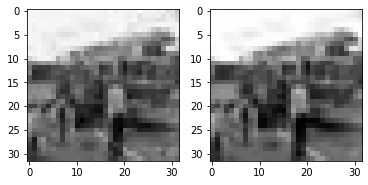

True label: 9
predicted label: 7
Time:  622.9277837276459  seconds
Initial fitness: 
 [-0.6011767585307207, -0.6002804016925765, -0.60002659077317, -0.6005974913040661, -0.6015561064745197, -0.6003503618835334, -0.6023021247552299, -0.6006818625736718, -0.6003758609992607, -0.6011334403348763, -0.6004346789881255, -0.6010664550874795, -0.6013385246185878, -0.6002874438122214, -0.6002588527356865, -0.6015682175705763, -0.601144443484927, -0.6003914864265929, -0.600606508917813, -0.601156324312633, -0.5999757350793389, -0.6004337768378896, -0.6000317177719215, -0.5999482247476895, -0.6000280560516043, -0.600626913480006, -0.6004542221039939, -0.6002757142493546, -0.6000961789014386, -0.6001297600702402, -0.6011530934985213, -0.6004465803686181, -0.6008506672322802, -0.6011061519062784, -0.6000616113550836, -0.6006967272774498, -0.6002689069935623, -0.6000171396741731, -0.6000696023129586, -0.6006399809257917, -0.6003062209907789, -0.6003208038752589, -0.602704183734551, -0.60259863859544

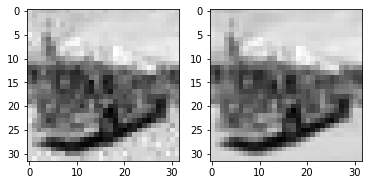

True label: 9
predicted label: 6
Time:  495.1345570087433  seconds
Initial fitness: 
 [-0.6001091808570785, -0.6000723931707516, -0.6001938097473017, -0.6000632848474954, -0.6001169698306628, -0.6004944595866956, -0.6002067927549279, -0.6001696840771091, -0.6000696178384263, -0.6000864021164458, -0.6003956264225346, -0.600762246277451, -0.6003930790481594, -0.6000314768797099, -0.6001050528178868, -0.6004896216757325, -0.6000404409912521, -0.6000929799171963, -0.6003626878870867, -0.600172768703296, -0.6000583148569514, -0.6000486348166107, -0.600271928011513, -0.6001579890430191, -0.6002707866512005, -0.6002552946824569, -0.6000931930252549, -0.6002137430883576, -0.6001003160310526, -0.6000713838936435, -0.6007640123065355, -0.6000152970313296, -0.600050745023549, -0.6001340735360182, -0.6001832081644214, -0.6008412147133474, -0.6001889407623091, -0.6005530949934527, -0.6000901596162378, -0.6002377442883198, -0.6002131789493108, -0.6000949046615545, -0.6002808464265371, -0.60034638373

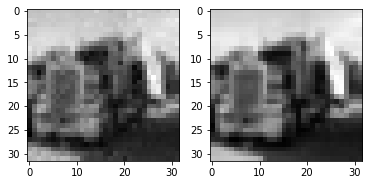

True label: 9
predicted label: 6
Time:  790.5110056400299  seconds
Initial fitness: 
 [0.4946496802631384, 0.3818452647587651, 0.42686089583603837, 0.3662851669899406, 0.15030896308044528, 0.11489548949703951, 0.4602537501920647, 0.2596966657884776, 0.28175074742985395, 0.23779018565766213, 0.38705395916340746, 0.3523509318651318, 0.45637440926042916, 0.33124239330548894, 0.3509127586448405, 0.2616203906628408, -0.03734985626212747, 0.36585106978969445, 0.13715127117888262, 0.3588840637588783, 0.3358442207487942, 0.2372071668025415, 0.42619166904166117, 0.4368858470151312, 0.31750556921189277, 0.35029863939739253, 0.512120985830605, 0.44875724983131204, 0.29829279865590824, 0.29281122914631064, 0.45624348902824857, 0.39656309354231783, 0.19597068253930022, 0.36628219444311, 0.4992938131899801, 0.43021235337984265, 0.17344790231707832, 0.2225126079138552, 0.18147415046549892, 0.4006512951702448, 0.09852301446766629, 0.499909310879938, 0.42007030911955556, 0.297600533064964, 0.3273970541

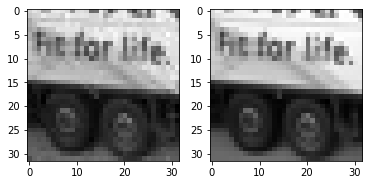

True label: 9
predicted label: 1
Time:  593.7179520130157  seconds


In [15]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)

  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = uniform(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [16]:
import pickle
file_ = open('GA_cifar_ssim_uniform_seed1', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 9251.166460514069
Min time: 110.74935054779053
Mean time: 538.3340680455804
Std time: 805.2348181299922

Max fitness evolved: 0.999099022609342
Min fitness evolved:: -0.6038398508417198
Mean fitness evolved: 0.8724454311790423
Std fitness evolved:: 0.4200386204413027

Max ssim: 0.34063653072994315
Min ssim: 2.1461760376539907e-05
Mean ssim: 0.034887092308840906
Std ssim: 0.04179364851516044

Max round: 352
Min rounds: 30
Mean rounds: 113.13533834586467
Std rounds: 62.87507388953786

Percentage of adversarial founds sucessfully : 0.0 %
Percentage of adversarial founds after fitness not improving for 30 generations: 1.0 %


Open adversarial

In [16]:
with open('GA_cifar_ssim_uniform_seed1', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [17]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.9999751055105216
Min ssim: 0.6384591901365775
Mean ssim: 0.9558347770684832
Std ssim: 0.04848948770264251



In [18]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 
number_of_rounds

array([124,  66,  43, 142,  57,  51, 159, 162,  75,  39,  90,  54,  78,
       200,  55,  30,  49,  48,  72,  30,  70,  30,  58,  30,  30, 221,
        47,  44,  77, 166,  49,  73,  68,  62, 160,  54,  30,  30, 163,
        41,  60, 126, 131,  50,  56, 123,  59, 103,  87, 163,  65,  51,
        30,  57,  62,  82,  43,  73,  54,  35, 143,  56,  47,  93,  53,
        48,  53,  87,  50, 258,  73,  44, 119,  88, 122, 202, 120, 312,
       105,  53, 215,  69,  54, 181,  74,  59, 152,  57, 122,  92, 103,
        82, 140, 150,  52, 236,  66,  83, 106,  55,  75,  50, 141,  89,
       164, 111, 199, 163,  50, 106, 109, 125,  68,  71,  62,  76,  30,
        97,  50, 245,  83, 105, 160,  99,  30, 163, 194, 209,  74,  65,
        63, 248, 100])

In [19]:
print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")



Max round: 312
Min rounds: 30
Mean rounds: 94.62406015037594
Std rounds: 57.384811265406334



# Examples of what functions do

In [20]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

[-0.7985465162923521, -0.7986143083750571, -0.7987471051598604, -0.7985707668610373, -0.7982924257403384, -0.7986327403276119, -0.7985371486357186, -0.7985994008038856, -0.7986489211692849, -0.7986328414261329, -0.7984458209104648, -0.7984243186786316, -0.7986808364148438, -0.7985361335297634, -0.7986223931863521, -0.7985934793588448, -0.7985824238975603, -0.7988441971646905, -0.7987014476161194, -0.7985461135578481, -0.7990548797213475, -0.7987683905017589, -0.7987217591636139, -0.7982758675457193, -0.7985617593840181, -0.7985848285873556, -0.7987301557841994, -0.7991410791966216, -0.7986603301300249, -0.7985413760052505, -0.7987699575381428, -0.7985720458357408, -0.798955996097742, -0.798579105842811, -0.7985950601799465, -0.7988551747635011, -0.7987739212531476, -0.7986167813577487, -0.7987854349489499, -0.7986451627215853, -0.7987192631907932, -0.7984980869985312, -0.7988911513972523, -0.7990398345027385, -0.7987669523115083, -0.7986125483502851, -0.7986265189097643, -0.79865529576

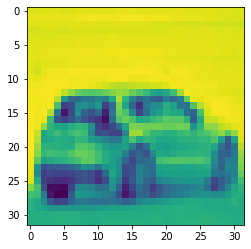

Class for this 1
[[2.6434999e-10 1.0000000e+00 7.0909743e-14 4.5650541e-12 4.3118281e-13
  1.4432735e-13 1.0789726e-12 1.0530981e-12 1.4951328e-13 4.9216830e-08]]


In [21]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [22]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

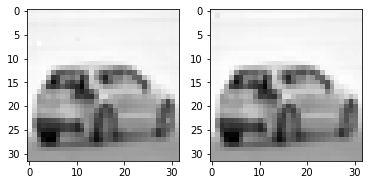

In [23]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [24]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

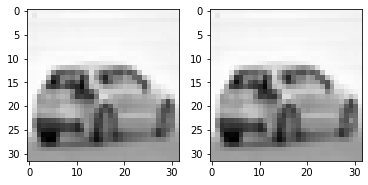

In [25]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [26]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

diff between children [-26.474258  -11.0143585  -6.996811   -5.0584183  -4.2319946   0.
  16.191185   23.026329 ]
diff between parents [-23.026329  -16.191185   -7.238968    0.          0.9351196   3.4584656
   4.2319946   5.0584183   6.996811    8.899292   10.452713   11.0143585
  14.125168   16.190605   26.474258 ]
diff between p1 and c1 [-23.026329  -16.191185   -7.238968    0.          4.2319946   5.0584183
   6.996811   10.452713   11.0143585  14.125168   26.474258 ]
diff between p1 and c2 [-7.238968  0.       10.452713 14.125168]
diff between p2 and c1 [-16.190605   -8.899292   -3.4584656  -0.9351196   0.       ]
diff between p2 and c2 [-26.474258  -16.190605  -11.0143585  -8.899292   -6.996811   -5.0584183
  -4.2319946  -3.4584656  -0.9351196   0.         16.191185   23.026329 ]


In [27]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

In [28]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

[0.8014533883402163, 0.8013855962575113, 0.801252799472708, 0.8014289470366678, 0.8017074788922299, 0.8013671643049565, 0.8014627559968498, 0.8014005038286828, 0.8013509834632835, 0.8013668724715722, 0.8015540837221036, 0.801575299851642, 0.8013190682177246, 0.801463771102805, 0.8013775114462163, 0.8014064252737235, 0.8014174807350081, 0.8011557074678779, 0.8012985523838807, 0.8014537910747203, 0.8009450249112209, 0.8012315141308095, 0.8012782408363862, 0.801724037086849, 0.8014381452485503, 0.8014150760452128, 0.8012695581135058, 0.8008578717616304, 0.8013393837676802, 0.8014585286273178, 0.8012297563595623, 0.8014278587968275, 0.8010439085348263, 0.8014207987897574, 0.8014048444526218, 0.8011444437667725, 0.8012257926445575, 0.8013829325399564, 0.8012141835813237, 0.8013547419109831, 0.8012804507069119, 0.8015015315317424, 0.8011083717655896, 0.8009598793949666, 0.8012327615861968, 0.8013871655474201, 0.801373385722804, 0.801344608872052, 0.8014492399679474, 0.8012973028671962]
